In [1]:
import time
import gym
import numpy as np
import control as ct
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as reg
from tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
import os
tf.enable_eager_execution()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
class MVNFull():
    def __init__(self, loc,covariance_matrix):
        self.loc = loc
        self.cov = covariance_matrix
        self.shape = tf.cast(self.cov.shape[-1],dtype=tf.float64)
#         print(self.loc.shape)
#         print(self.cov.shape)
        assert(self.loc.shape[-2]==self.cov.shape[-1]), "mean and covariance must have same n"
        assert(self.cov.shape[-1]==self.cov.shape[-2]),'covariance must have shape [...,n,n]'
        
    def log_prob(self, value):
        value = value
#         print('Inside prob function')
#         print('value',value)
        assert(value.shape[-1]==self.loc.shape[-1] and value.shape[-2]==self.loc.shape[-2]),'value must have same last 2 dimensions as loc'
#         print('cov',self.cov.shape)

#         print('cov',self.cov)
        cov_inv = tf.linalg.inv(self.cov+1e-8*tf.eye(self.shape,dtype=tf.float64))
#         cov_inv = None
#         multiplier = 1e-8
#         while cov_inv == None:
#             try:
#                 if multiplier != 1e-8:
#                     print('MVNFull covariance inverser failed, trying identity multiplier ',multiplier)
#                 cov_inv = tf.linalg.inv(self.cov+multiplier*tf.eye(self.shape, dtype = tf.float64))
#             except:
#                 multiplier *= 10
#         print('cov_inv',cov_inv)
#         print('cov_inv',cov_inv.shape)
#         print(cov_inv.numpy())
        cov_det = tf.linalg.det(self.cov)+1e-16
#         print('cov_det', cov_det.numpy())
#         print(cov_det.numpy())
        denomenator = tf.math.sqrt(tf.math.pow((tf.cast(2*np.pi,dtype = tf.float64)),self.shape)*cov_det)+1e-32
#         print('denomenator', denomenator.numpy())
        diff = value-self.loc
#         print('diff', diff.numpy())
        numerator = tf.squeeze(tf.math.exp((-0.5)*tf.matmul(tf.matmul(diff,cov_inv, transpose_a=True),diff)))+1e-16
#         print('numerator', numerator.numpy())
#         print('final value', tf.math.log(tf.math.divide(numerator,denomenator)).numpy())
#         print('leaving prob function')
        return tf.math.log(tf.math.divide(numerator,denomenator))

In [3]:
def forward_filter_fn(A,B,u,g,C,sigma,l_a_posteriori,P_a_posteriori,z):
    '''Calculates prior distribution based on the previous posterior distribution
        and the current residual updates posterior distribution based on the new
        prior distribution
    '''
#     print('z',z)
#     print('A', A)
#     print('B',B)
#     print('u',u)
#     print('g',g)
#     print('sigma',sigma)
#     print('C', C)
#     print('l_a_posteriori', l_a_posteriori)
#     print('P_a_posteriori', P_a_posteriori)
    _I = tf.eye(int(A.shape[0]), dtype = tf.float64)
    
    z = tf.expand_dims(z,-1)
    l_a_priori = tf.matmul(A,l_a_posteriori) + tf.matmul(B,u)
#     print('l_a_priori',l_a_priori)
    P_a_priori = tf.matmul(tf.matmul(A,P_a_posteriori), A, transpose_b = True) + tf.matmul(g,g, transpose_b=True)
#     print('P_a_priori',P_a_priori)
    y_pre = z - tf.matmul(C,l_a_priori)
#     print('y_pre', y_pre)

    S = tf.matmul(sigma, sigma, transpose_b=True) + \
        tf.matmul(tf.matmul(C, P_a_priori), C, transpose_b=True)
#     print('S',S)
    S_inv = tf.linalg.inv(S+1e-8*tf.eye(int(C.shape[0]), dtype = tf.float64))
#     S_inv = None
#     try:
#         S_inv = tf.linalg.inv(S)
#         print('success?')
#     except InvalidArgumentError:
#         print('Outer except')
#         multiplier = 1e-10
#         while S_inv == None:
#             try:
#                 if multiplier != 1e-10:
#                     print('KF inv failed, trying identity multiplier ',multiplier)
#                 cov_inv = tf.linalg.inv(self.cov+multiplier*tf.eye(S.shape[0], dtype = tf.float64))
#             except InvalidArgumentError:
#                 multiplier *= 10
#         pass


#     print('S_inv', S_inv)
    K = tf.matmul(tf.matmul(P_a_priori, C, transpose_b=True), S_inv)
#     print('K', K)
    l_a_posteriori = l_a_priori + tf.matmul(K,y_pre)
#     print('l_a_posteriori', l_a_posteriori)
    I_KC = _I-tf.matmul(K,C)
#     print('I-KC', I_KC)
    P_a_posteriori = tf.matmul(tf.matmul(I_KC, P_a_priori), I_KC, transpose_b=True) + \
                        tf.matmul(tf.matmul(K,tf.matmul(sigma, sigma, transpose_b = True)),
                                K, transpose_b=True)
#     print('P_a_posteriori',P_a_posteriori)
    y_post = z-tf.matmul(C,l_a_posteriori)
    squared_error = tf.squeeze(tf.matmul(y_post,y_post, transpose_a=True))
#     print(squared_error)
#     print('y_post', y_post)
    pred = tf.matmul(C, l_a_posteriori)
#     print('pred', pred)
        
    return A,B,u,g,C,sigma,l_a_posteriori,P_a_posteriori,z, pred, squared_error

In [12]:
class Model(object):
    def __init__(self, thetaacc_error = 0, env_params_variation = [0,0,0,0], initial_state_variation = [0,0,0,0], control = False):
        self.m = 4
        self.dim_z = self.m
        self.n = 4
        self.r = 1
        self.lstm_input_dim = self.m+4
        self.sigma_upper_bound = 1
        self.sigma_lower_bound = 0
        self.g_upper_bound = 1
        self.g_lower_bound = 0
        self.mu_0_upper_bound = 1
        self.mu_0_lower_bound = 0
        self.Sigma_0_upper_bound = 1
        self.Sigma_0_lower_bound = 0
        self.weight_beta = 10
        self.bias_beta = 10
        thetaacc_error = 0
        self.global_epoch = 0
        
        self.mu_0_dense = layers.Dense(self.m, activation = tf.nn.leaky_relu, kernel_regularizer = reg.l2(self.weight_beta),
                                       bias_regularizer = reg.l2(self.bias_beta),name = 'mu_0_dense')
        self.Sigma_0_dense = layers.Dense(self.m, activation = tf.nn.leaky_relu, kernel_regularizer = reg.l2(self.weight_beta),
                                          bias_regularizer = reg.l2(self.bias_beta),name = 'Sigma_0dense')
        self.A_dense = layers.Dense(self.m*self.n, activation = tf.nn.leaky_relu, kernel_regularizer = reg.l1(self.weight_beta),
                                    bias_regularizer = reg.l2(self.bias_beta),name = 'A_dense')
        self.g_dense = layers.Dense(self.m, activation = tf.nn.leaky_relu, kernel_regularizer = reg.l1(self.weight_beta),
                                    bias_regularizer = reg.l2(self.bias_beta),name = 'g_dense')
        self.sigma_dense = layers.Dense(self.dim_z, activation = tf.nn.leaky_relu, kernel_regularizer = reg.l1(self.weight_beta),
                                         bias_regularizer = reg.l2(self.bias_beta),name = 'sigma_dense')
        
        '''Temporary LQR variables'''
        self.Q = np.eye(4)*[1,1,1,1]
        self.R = 1

        self.initial_variance_estimate = 1

        self.lstm_sizes = [128,64]
        self.env = gym.make('Custom_CartPole-v0', thetaacc_error=thetaacc_error, initial_state_var=initial_state_variation)
        gravity = self.env.gravity
        cart_mass = self.env.masscart
        pole_mass = self.env.masspole
        pole_length = self.env.length
        self.env_params = tf.expand_dims(np.array([gravity, cart_mass,pole_mass,pole_length],
                                             dtype=np.float64),0)
        self.control = control
        self.variables = []
        
    def build_LSTM(self):
        lstms = [tf.contrib.rnn.LSTMCell(size, reuse=tf.get_variable_scope().reuse) for size in self.lstm_sizes]
        dropouts = [tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob = 0.5) for lstm in lstms]

        self.cell = tf.contrib.rnn.MultiRNNCell(dropouts)
#         print(self.cell.trainable_variables)
#         print(self.cell.trainable_weights)
#         self.variables.append(self.cell.trainable_variables)
        return self
    
    def get_variables(self):
        return self.variables
    def reset_variables(self):
        self.variables = []
        return self
    def set_control(self, control):
        self.control = control
        return self
    
    def likelihood_fn(self, params, inputs):
        A, B, u, g, C, sigma, l_filtered, P_filtered = inputs
        mu_1, Sigma_1 = params
#         print('A',len(A))
#         print('B',len(B))
#         print('u',len(u))
#         print('C',len(C))
#         print('g',len(g))
#         print('sigma',len(sigma))
#         print('l_filtered',len(l_filtered))
#         print('p_filtered',len(P_filtered))
#         print('mu_1',mu_1.shape)
#         print('Sigma_1',Sigma_1.shape)
        mu = [mu_1]
        Sigma = [Sigma_1]
        assert(len(A)==len(B) and len(B)==len(u) and len(u)==len(C) and len(C)==len(sigma) and 
               len(sigma)==len(l_filtered) and len(l_filtered)==len(P_filtered)),"Not all sequences are same length"
        for i in range(len(A)):
            mu.append(tf.matmul(C[i], tf.add(tf.matmul(A[i],l_filtered[i]), tf.matmul(B[i],u[i]))))
            temp = tf.matmul(tf.matmul(A[i], P_filtered[i]), A[i], transpose_b=True) + \
                        tf.matmul(g[i], g[i], transpose_b=True)
            Sigma.append(tf.matmul(tf.matmul(C[i], temp), C[i], transpose_b=True) + \
                        tf.matmul(sigma[i],sigma[i],transpose_b=True))
        return mu,Sigma
    
    def step(self,output_single):
        A = self.A_dense(output_single)
        g = self.g_dense(output_single)
        sigma = self.sigma_dense(output_single)
        A = tf.reshape(A, shape = (self.m,self.n))
        g = tf.reshape(g, shape = (self.m, 1))
        sigma = tf.reshape(sigma,shape = (self.dim_z,1))
        g = ((self.g_upper_bound-self.g_lower_bound)/(1+tf.exp(-g)))+self.g_lower_bound
        sigma = ((self.sigma_upper_bound-self.sigma_lower_bound)/(1+tf.exp(-sigma)))+self.sigma_lower_bound
        return A, g, sigma
    
    def __call__(self, view = False):
        self.reset_variables()
        rewards = 0
        A_all = []
        B_all = []
        u_all = []
        g_all = []
        C_all = []
        sigma_all = []
        l_a_posteriori = []
        P_a_posteriori = []
        env_states = []
        preds = []
        squared_error = []
        all_KF_params = [A_all,B_all,u_all,g_all,C_all,sigma_all,
                         l_a_posteriori,P_a_posteriori,env_states,preds,
                         squared_error]

        '''p-quantile loss'''
        Q50_numerator = np.zeros(4)
        Q90_numerator = np.zeros(4)
        
        '''Build LSTM'''
        self.build_LSTM()
        
        '''Start gym environment'''
        observation=self.env.reset()

        '''Get initial lstm state and input, get first output/state'''
        initial_state = self.cell.get_initial_state(batch_size=1,dtype = tf.float64)
        initial_input = tf.concat((self.env_params,tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float64),0)),
                                  axis=1)
#         initial_input = tf.concat((self.env_params, np.zeros(shape=(1,4)),axis=1)
        output_single, state_single = self.cell(inputs=initial_input, state=initial_state)
#         self.variables.extend(self.cell.trainable_variables)

#         print('LSTM cell trainable',len(self.cell.trainable_variables))
#         print('Rewards', self.rewards)
#         print('VARIABLES',[x.name for x in self.cell.trainable_variables])
#         print('\n\n\nWEIGHTS',[x.name for x in self.cell.trainable_weights])
        '''Calculate mu_0,Sigma_0, distribution using initial LSTM output'''
        container = tf.contrib.eager.EagerVariableStore()
        with container.as_default():
            mu_0 = self.mu_0_dense(output_single)
            Sigma_0 = self.Sigma_0_dense(output_single)
        mu_0 = tf.reshape(mu_0, shape = (self.m,1))
#         print(Sigma_0)
        mu_0 = ((self.mu_0_upper_bound-self.mu_0_lower_bound)/(1+tf.exp(-mu_0)))+self.mu_0_lower_bound
        Sigma_0 = tf.reshape(Sigma_0, shape = (self.m,1))
        Sigma_0 = ((self.Sigma_0_upper_bound-self.Sigma_0_lower_bound)/(1+tf.exp(-Sigma_0)))+\
                        self.Sigma_0_lower_bound
#         print(Sigma_0)
        Sigma_0 = tf.matmul(Sigma_0,Sigma_0,transpose_b=True)+tf.eye(4, dtype=tf.float64)
        Sigma_0 = 0.5*(Sigma_0+tf.transpose(Sigma_0))
#         print(Sigma_0)
        l_0_distribution = tfd.MultivariateNormalFullCovariance(loc = tf.squeeze(mu_0),
                                                                covariance_matrix= Sigma_0,
                                                                validate_args=True)
        l_0 = tf.expand_dims(l_0_distribution.sample(),1)
        l_a_posteriori.append(l_0)
        P_a_posteriori.append(self.initial_variance_estimate*tf.eye(self.m, dtype = tf.float64))
#         print(Sigma_0)
        first_pass = True
        done = False
        while not done:
            if view:
                self.env.render()
            '''Get lstm outputs'''
            with container.as_default():
                A, g, sigma = self.step(output_single)
            if self.control:
                B = tf.layers.dense(output_single, self.m*self.r, kernel_regularizer = reg.l1(self.weight_beta),
                                    bias_regularizer = reg.l2(self.bias_beta),
                                    name = 'B_dense', reuse = True)
                B = tf.reshape(B, shape = (self.m,self.r))
                K,S,E = ct.lqr(A.numpy(),B.numpy(),self.Q,self.R)
                u = -tf.matmul(K.astype(np.float64),tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float64),-1))
            else:
                B = tf.zeros(shape = (self.m,self.r), dtype = tf.float64)
                u = tf.zeros(shape = [1,self.r], dtype=tf.float64)

            '''If this is first pass in loop, add variables to graph'''
            if first_pass:
                self.variables.extend(container.trainable_variables())
                first_pass = False
            
            C = tf.eye(self.dim_z, dtype = tf.float64)
            observation, reward, done, info = self.env.step(tf.squeeze(u))
            '''Calculate:
                A,B,u,g,C,sigma,l_a_posteriori,P_a_posteriori,env_states'''
            KF_update = forward_filter_fn(A, B, u,g, C, sigma,l_a_posteriori[-1],P_a_posteriori[-1],
                                          tf.convert_to_tensor(observation,dtype=tf.float64))
            '''Update lists:
                A_all,B_all,u_all,g_all,C_all,sigma_all,l_a_posteriori,P_a_posteriori,env_states'''
            for KF_single,KF_param  in zip(KF_update,all_KF_params):
                KF_param.append(KF_single)
            next_input = tf.concat((self.env_params,tf.transpose(env_states[-1])),axis=1)
            output_single,state_single=self.cell(inputs=next_input,state=state_single)
            rewards+=1
        if view:
            self.env.close()

#         param_names = ['A_all','B_all','u_all','g_all','C_all','sigma_all',
#                        'l_a_posteriori','P_a_posteriori','env_states','preds']
#             for name,KF_param in zip(param_names,all_KF_params):
#                 print(name,len(KF_param), KF_param[0].shape)


        mu_1 = tf.add(tf.matmul(A_all[0], mu_0),tf.matmul(B_all[0],u_all[0]))
        Sigma_1 = tf.add(tf.matmul(tf.matmul(C_all[0],Sigma_0),C_all[0], transpose_b=True),
                     tf.matmul(sigma_all[0],sigma_all[0],transpose_b=True))
#         print(mu_1.shape)
#         print(Sigma_1.shape)
        if rewards > 1:
            mu,Sigma = self.likelihood_fn((mu_1,Sigma_1),(A_all,B_all,u_all,g_all,
                                                     C_all,sigma_all,
                                                     l_a_posteriori[1:],
                                                     P_a_posteriori[1:]))

        '''p-quantile loss'''
        for i in range(Q50_numerator.shape[0]):
            for j in range(rewards):
                Q50_numerator[i] += QL(0.5, preds[j][i], env_states[j][i])
                Q90_numerator[i] += QL(0.9, preds[j][i], env_states[j][i])

        Q_denomenator = np.sum(np.abs(np.squeeze(np.array(env_states))), axis = 0)
        for idx,slot in enumerate(Q_denomenator):
            if slot==0:
                Q_denomenator[idx]+=np.abs(np.random.normal(loc = 0.0, scale = 1e-10))
        pq50_loss = 2*np.divide(Q50_numerator,Q_denomenator)
        pq90_loss = 2*np.divide(Q90_numerator,Q_denomenator)

        
        '''Compute Likelihood of observations given KF evaluation'''
        likelihoods = []
#         print(rewards)
        for i in range(rewards):
#             z_distribution = tfd.MultivariateNormalFullCovariance(loc = tf.squeeze(mu[i]), covariance_matrix = Sigma[i],validate_args=True)
            z_distribution = MVNFull(loc = mu[i], covariance_matrix = Sigma[i])
            likelihoods.append(z_distribution.log_prob(env_states[i]))
        
        self.global_epoch += 1
        return likelihoods, rewards, pq50_loss, pq90_loss, preds, env_states, squared_error

def QL(rho, z, z_pred):
    if z > z_pred:
        return rho*(z-z_pred)
    else:
        return (1-rho)*(z_pred-z)
    
def standard_loss(model,view):
    likelihoods, rewards, pq50_loss, pq90_loss, preds, trajectory, squared_error = model(view)
    loss = tf.Variable([0.0], trainable = False, dtype = tf.float64)
    for t,loss_term in enumerate(likelihoods):
        loss = tf.add(loss,-loss_term)
    return loss, rewards, pq50_loss, pq90_loss, preds, trajectory, squared_error

def inverse_multiplicative_loss(model,view):
    '''This gives loss terms which are a multiple of their time step'''
    likelihoods, rewards, pq50_loss, pq90_loss, preds, trajectory, squared_error = model(view)
    loss = tf.Variable([0.0], trainable = False, dtype = tf.float64)
    for t,loss_term in enumerate(likelihoods):
        loss = tf.add(loss,-(loss_term*(1/(t+1))))
    return loss, rewards, pq50_loss, pq90_loss, preds, trajectory, squared_error

def multiplicative_loss(model,view):
    '''This gives loss terms which are a multiple of their time step'''
    likelihoods, rewards, pq50_loss, pq90_loss, preds, trajectory, squared_error = model(view)
    loss = tf.Variable([0.0], trainable = False, dtype = tf.float64)
    for t,loss_term in enumerate(likelihoods):
        loss = tf.add(loss,-(loss_term*t))
    return loss, rewards, pq50_loss, pq90_loss, preds, trajectory, squared_error

def exponential_loss(model, view, alpha):
    '''For alpha > 1 this gives exponentially increasing loss
        For 0<alpha<1 this gives discounted loss'''
    likelihoods, rewards, pq50_loss, pq90_loss, preds, trajectory, squared_error = model(view)
    loss = tf.Variable([0.0], trainable = False, dtype = tf.float64)
    for t,loss_term in enumerate(likelihoods):
        loss = tf.add(loss,-(tf.exponent(alpha,t)*loss_term))
    return loss, rewards, pq50_loss, pq90_loss, preds, trajectory, squared_error
    

def compute_gradient(model, loss_type, alpha = None, view=False):
    with tf.GradientTape() as tape:
        if loss_type == 'standard':
            loss_value, rewards, pq50_loss, pq90_loss, preds,\
            trajectory, squared_error = standard_loss(model,view)
        elif loss_type == 'inverse_multiplicative':
            loss_value, rewards, pq50_loss, pq90_loss, preds,\
            trajectory, squared_error = inverse_multiplicative_loss(model,view)
        elif loss_type == 'multiplicative':
            loss_value, rewards, pq50_loss, pq90_loss, preds,\
            trajectory, squared_error = multiplicative_loss(model,view)
        elif loss_type == 'exponential':
            loss_value, rewards, pq50_loss, pq90_loss, preds,\
            trajectory, squared_error = exponential_loss(model, view, alpha)
#         print(tape.gradient(loss_value,epoch.get_variables()))
#         print(len(tape.watched_variables()))
#     print('model vars')
#     for var in model.get_variables():
#         print(var.name)
#     print('taped vars')
#     for var in tape.watched_variables():
#         print(var.name)
        
    return (tape.watched_variables(),tape.gradient(loss_value, tape.watched_variables()), loss_value.numpy(),\
            rewards, pq50_loss, pq90_loss, preds, trajectory, squared_error)

In [13]:
def train(model, num_epochs, optimizer, loss_type='standard', view_rate = False, clip_gradients = False):
    start = time.time()
    for i in range(num_epochs):
        if view_rate:
            if (model.global_epoch+1)%view_rate==0:
                watched_vars,grads, loss_, reward_, pq50, pq90, pred, trajectory,\
                    squared_error = compute_gradient(model, loss_type, view = True)
            else:
                watched_vars, grads, loss_, reward_, pq50, pq90, pred, trajectory,\
                    squared_error = compute_gradient(model, loss_type)
        else:
            watched_vars, grads, loss_, reward_, pq50, pq90, pred, trajectory,\
                    squared_error = compute_gradient(model, loss_type)
        '''Keep track of loss, rewards, etc.'''
        if model.global_epoch==1:
            for var in watched_vars:
                grad_norms.append([var.name])
        losses.extend(loss_)
        rewards.append(reward_)
        p50_losses.append(pq50)
        p90_losses.append(pq90)
        predicted_trajectories.append(pred)
        actual_trajectories.append(trajectory)
        squared_errors.append(squared_error)
        for idx, grad in enumerate(grads):
            grad_norms[idx].append(np.linalg.norm(grad))
            
        '''clip gradients'''
        '''Apply the gradient update to variables'''
        if clip_gradients:
            clipped_grads = [tf.clip_by_norm(grad, 1.) for grad in grads]
            optimizer.apply_gradients(zip(clipped_grads,watched_vars))
        else:
            optimizer.apply_gradients(zip(grads,watched_vars))
            
        if (model.global_epoch+1)%view_rate == 0:
            print('Epoch {}'.format(model.global_epoch+1))
            print('Minutes elapsed: {}'.format((time.time()-start)/60))
            print('Last {} averages: Loss: {}, reward: {}, loss/reward: {}'.format(view_rate,np.mean(losses[-view_rate:]), np.mean(rewards[-view_rate:]),
                                                                                   (np.mean(losses[-view_rate:])/np.mean(rewards[-view_rate:]))))
#             print('Model variables:')
#             for var in watched_vars:
#                 print(var)
            print()

In [14]:
model = Model(initial_state_variation=[0,0,0.01,0])
optimizer = tf.train.AdamOptimizer()
losses = []
rewards = []
p50_losses = []
p90_losses = []
model_vars = ['A_dense/bias:0', 'A_dense/kernel:0', 'B_dense/bias:0', 'B_dense/kernel:0',
              'Sigma_0dense/bias:0', 'Sigma_0dense/kernel:0', 'g_dense/bias:0', 'g_dense/kernel:0',
              'mu_0dense/bias:0', 'mu_0dense/kernel:0', 'sigma_dense/bias:0', 'sigma_dense/kernel:0',
              'multi_rnn_cell/cell_0/lstm_cell/kernel:0', 'multi_rnn_cell/cell_0/lstm_cell/bias:0',
              'multi_rnn_cell/cell_1/lstm_cell/kernel:0', 'multi_rnn_cell/cell_1/lstm_cell/bias:0']
grad_norms = []
predicted_trajectories = []
actual_trajectories = []
squared_errors = []


In [15]:
train(model,500,optimizer, view_rate = 25)
# train(model,200,tf.train.AdamOptimizer(1e-6),'multiplicative')

Epoch 25
Minutes elapsed: 0.779177709420522
Last 25 averages: Loss: 1844.902791541774, reward: 86.20833333333333, loss/reward: 21.4005157066228

Epoch 50
Minutes elapsed: 1.6063421249389649
Last 25 averages: Loss: 1792.338228631359, reward: 86.68, loss/reward: 20.67764453889431

Epoch 75
Minutes elapsed: 2.363129969437917
Last 25 averages: Loss: 1728.4558528027617, reward: 79.4, loss/reward: 21.76896540053856

Epoch 100
Minutes elapsed: 3.1223920901616413
Last 25 averages: Loss: 1716.3285995087117, reward: 79.12, loss/reward: 21.692727496318398

Epoch 125
Minutes elapsed: 3.85978285074234
Last 25 averages: Loss: 1676.6783779181026, reward: 77.08, loss/reward: 21.752443927323593

Epoch 150
Minutes elapsed: 4.6263049125671385
Last 25 averages: Loss: 1733.9081908492037, reward: 79.64, loss/reward: 21.77182560081873

Epoch 175
Minutes elapsed: 5.409774116675059
Last 25 averages: Loss: 1753.9258048783202, reward: 80.68, loss/reward: 21.739288607812593

Epoch 200
Minutes elapsed: 6.207143517

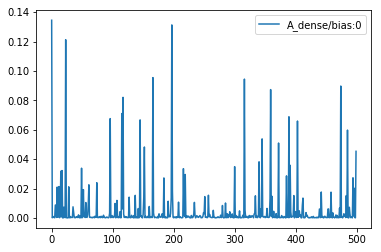

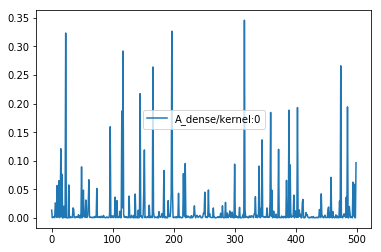

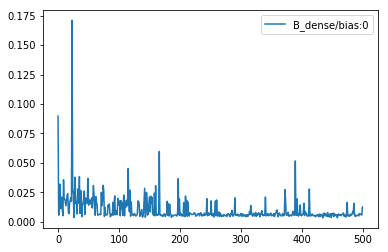

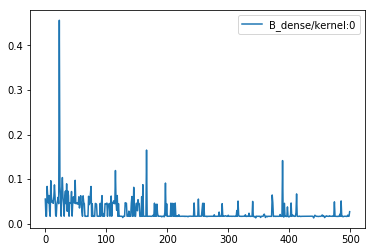

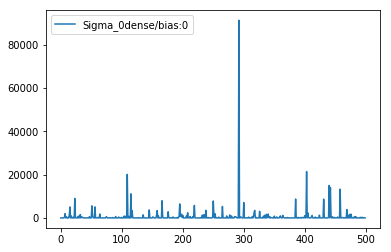

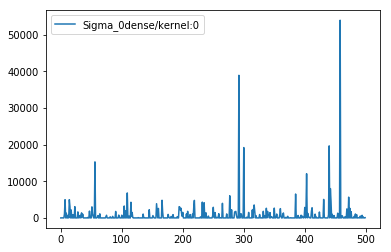

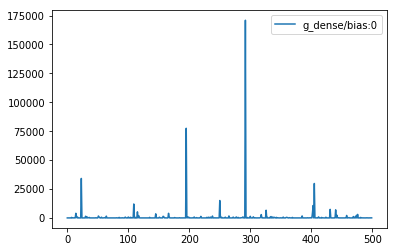

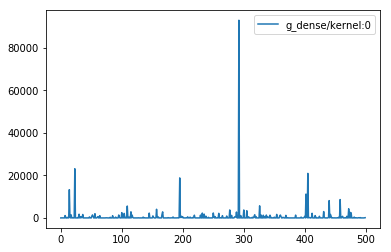

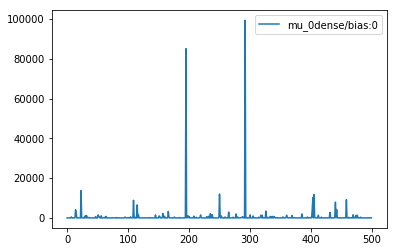

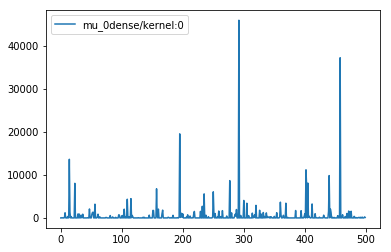

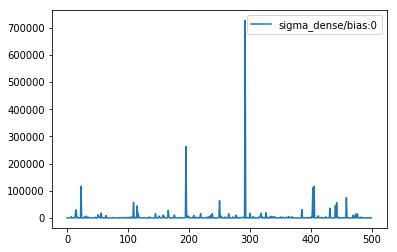

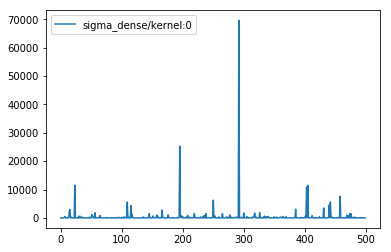

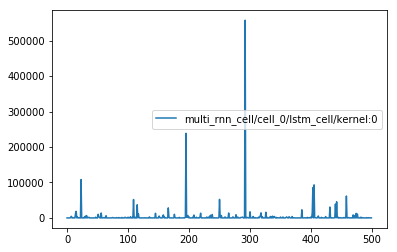

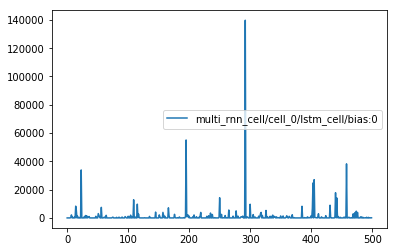

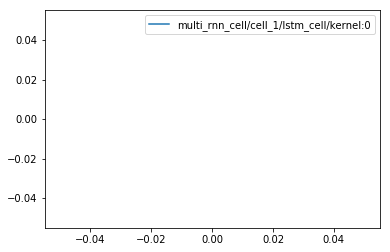

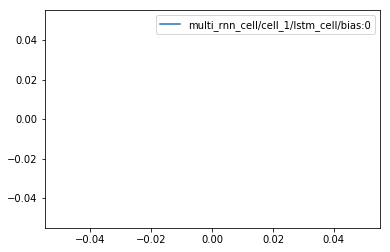

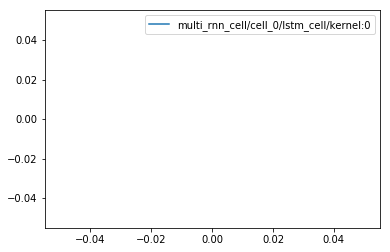

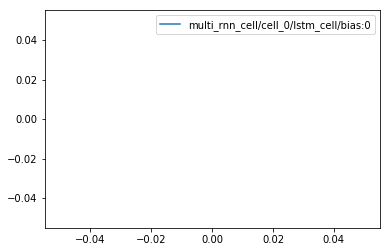

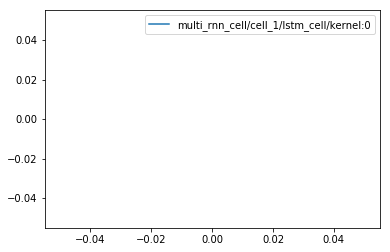

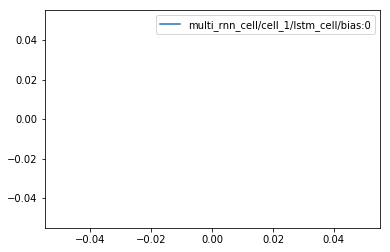

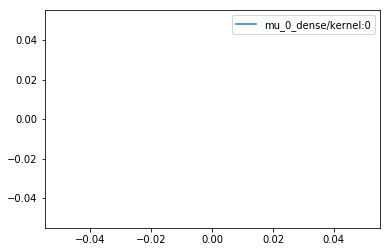

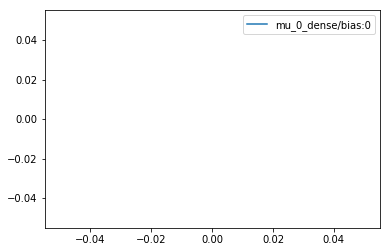

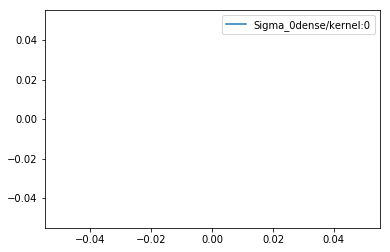

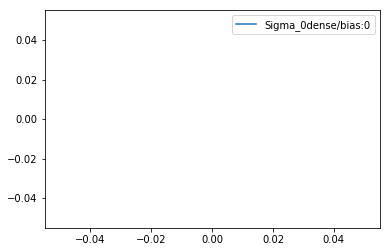

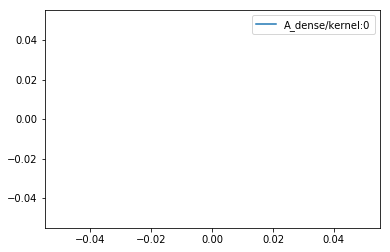

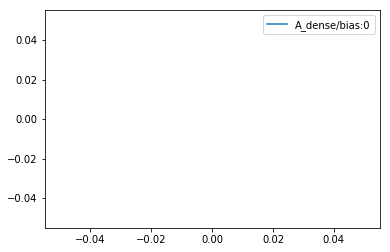

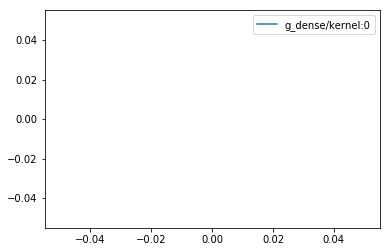

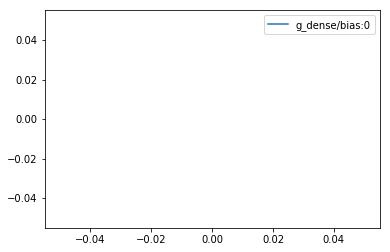

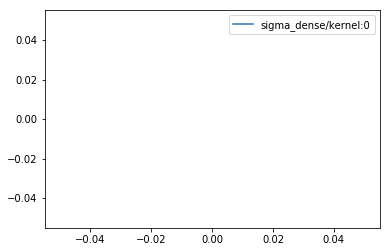

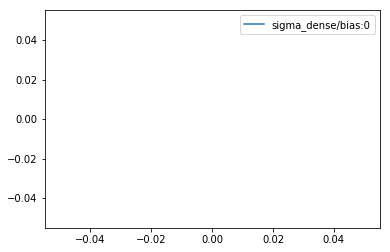

In [8]:
for var in grad_norms:
    plt.plot(var[1:], label = var[0])
    plt.legend()
    plt.show()

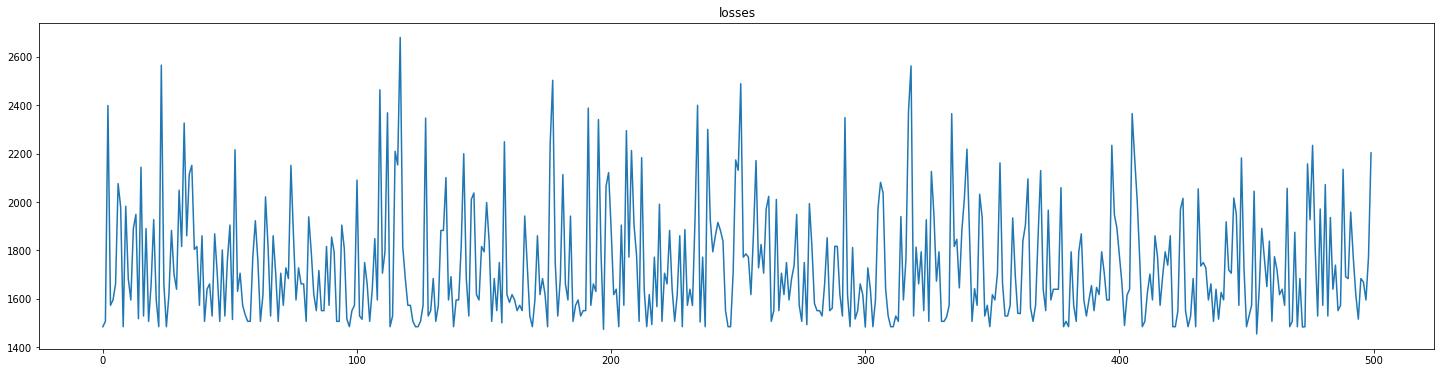

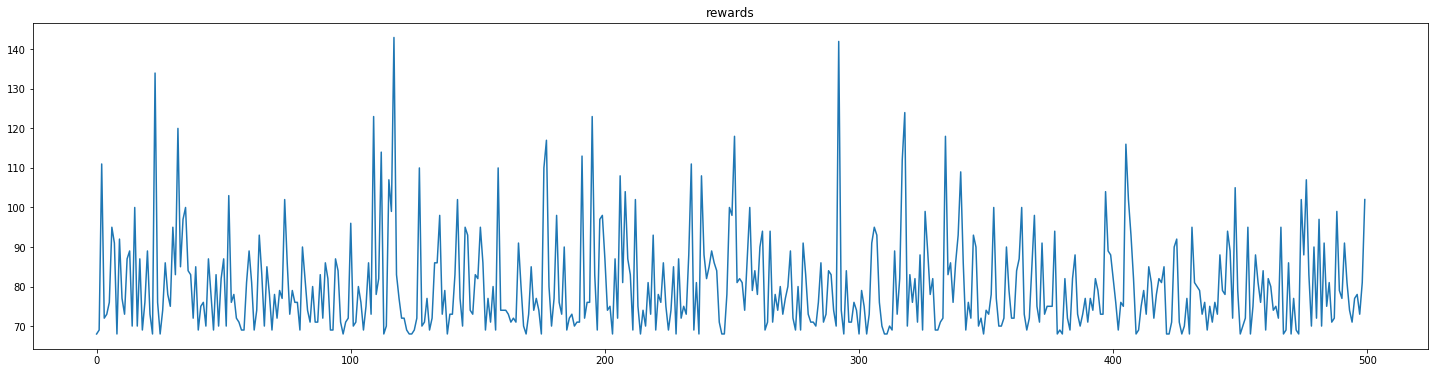

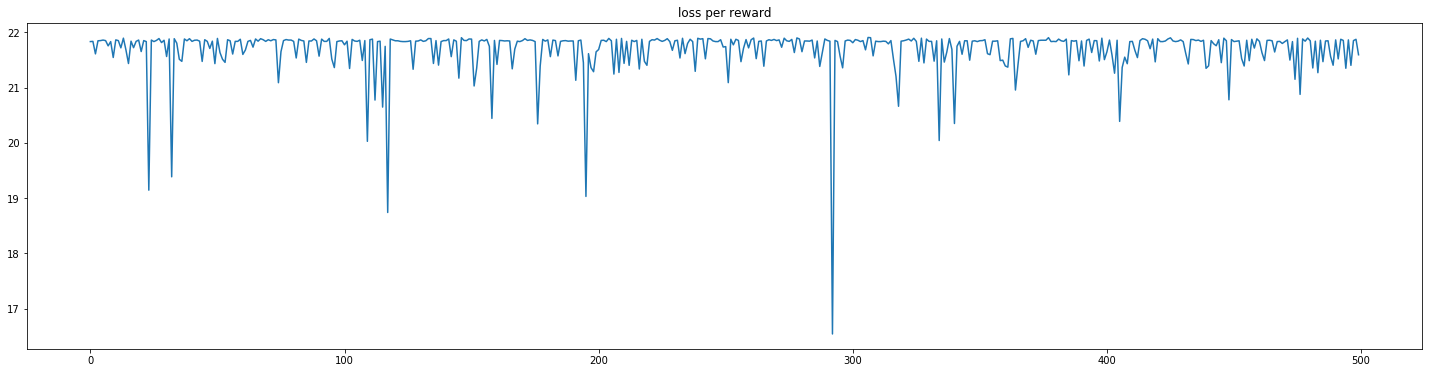

In [9]:
plt.figure(figsize=(25,6))
plt.plot(losses)
plt.title('losses')
plt.show()
plt.figure(figsize=(25,6))
plt.plot(rewards)
plt.title('rewards')
plt.show()
plt.figure(figsize=(25,6))
plt.plot([loss/reward for loss,reward in zip(losses,rewards)])
plt.title('loss per reward')
# plt.ylim(0,500)
plt.show()

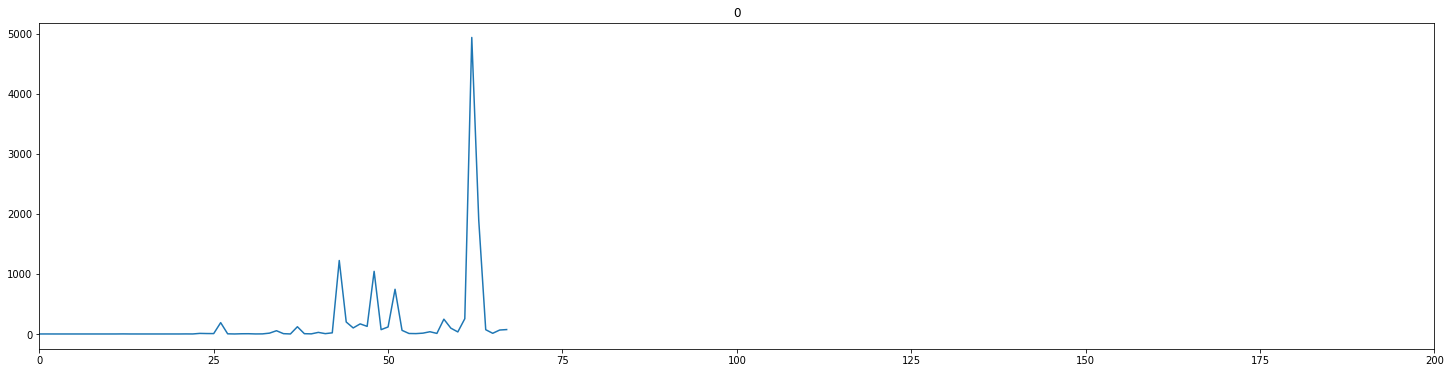

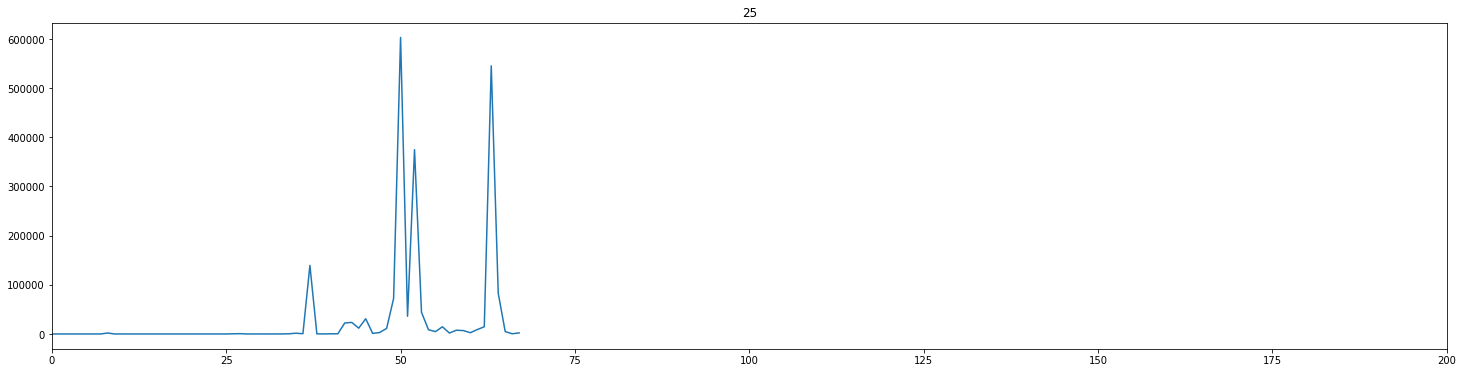

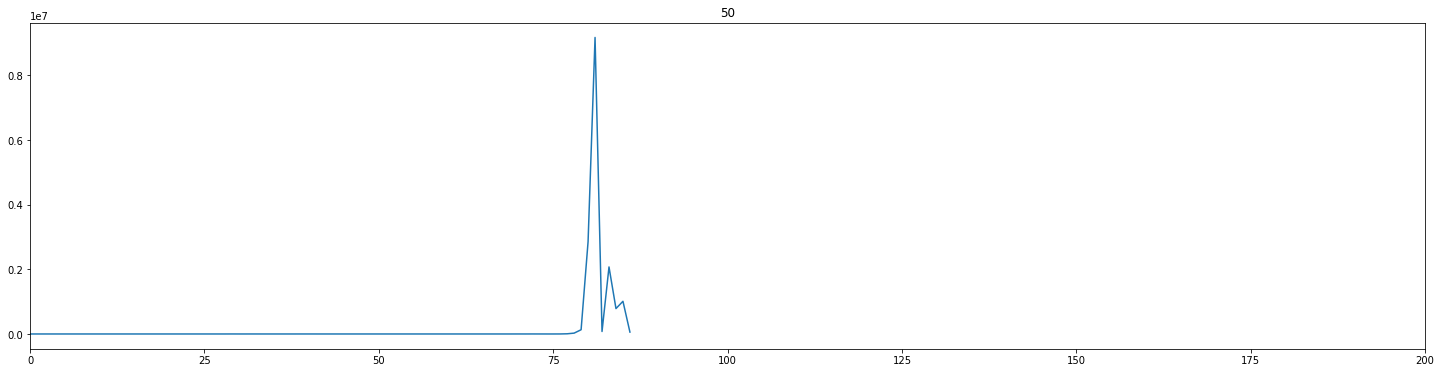

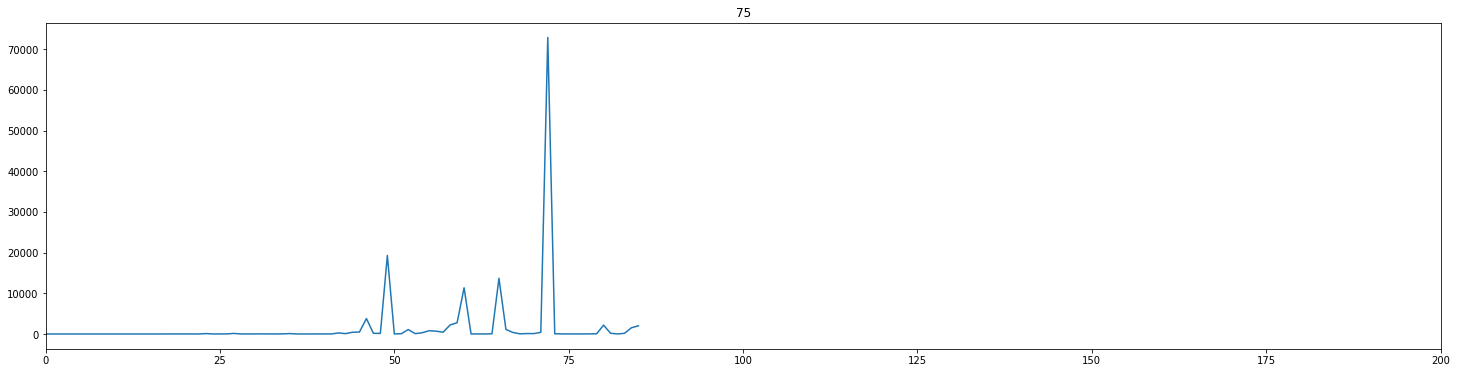

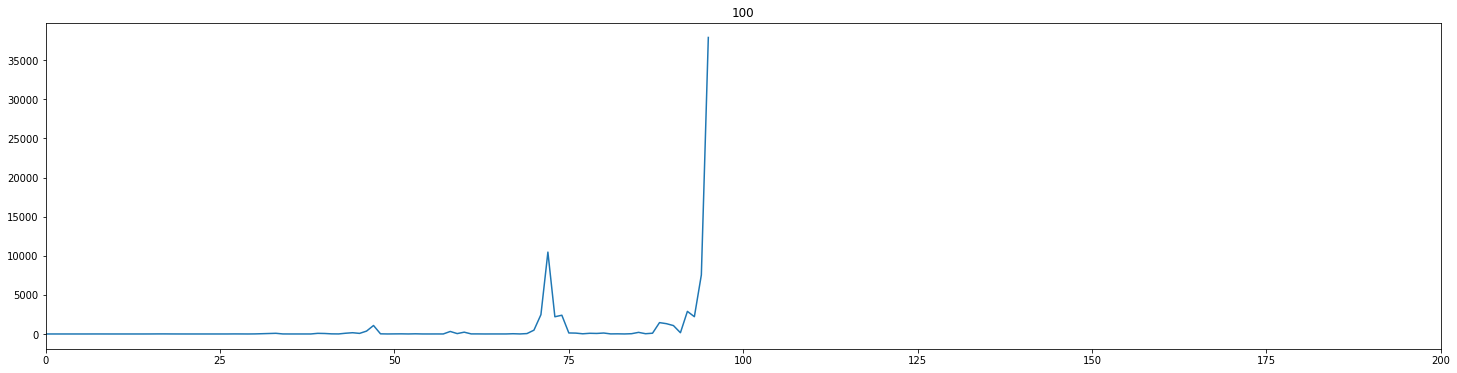

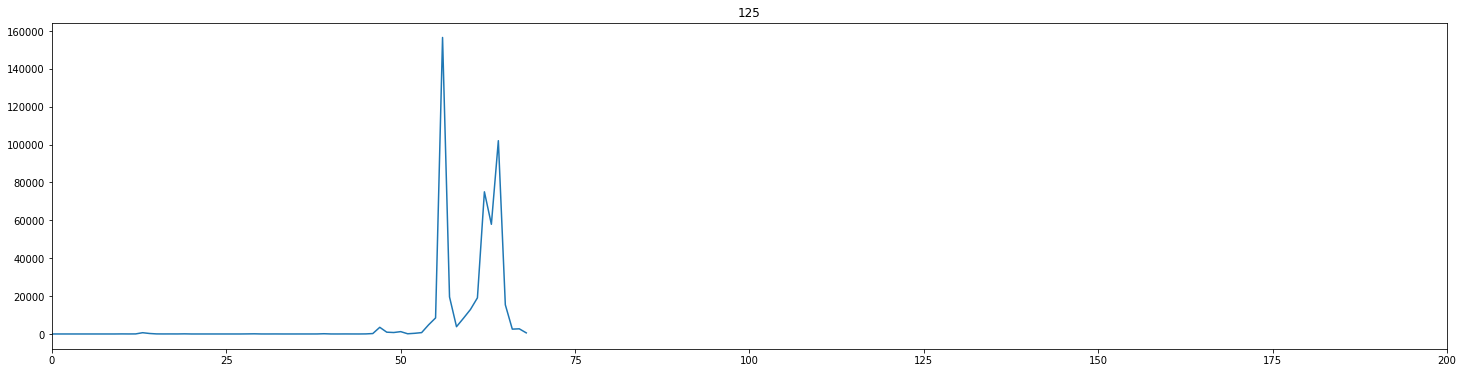

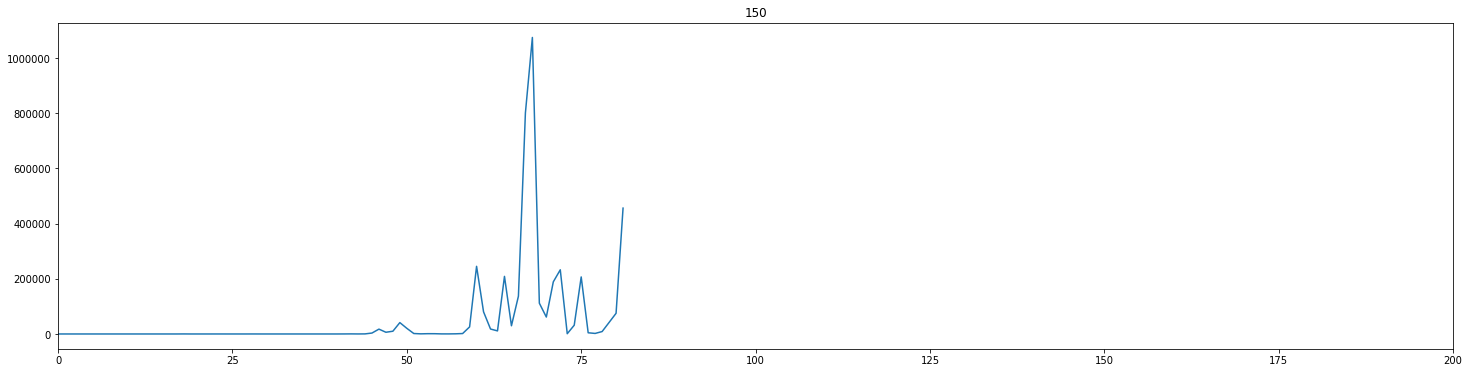

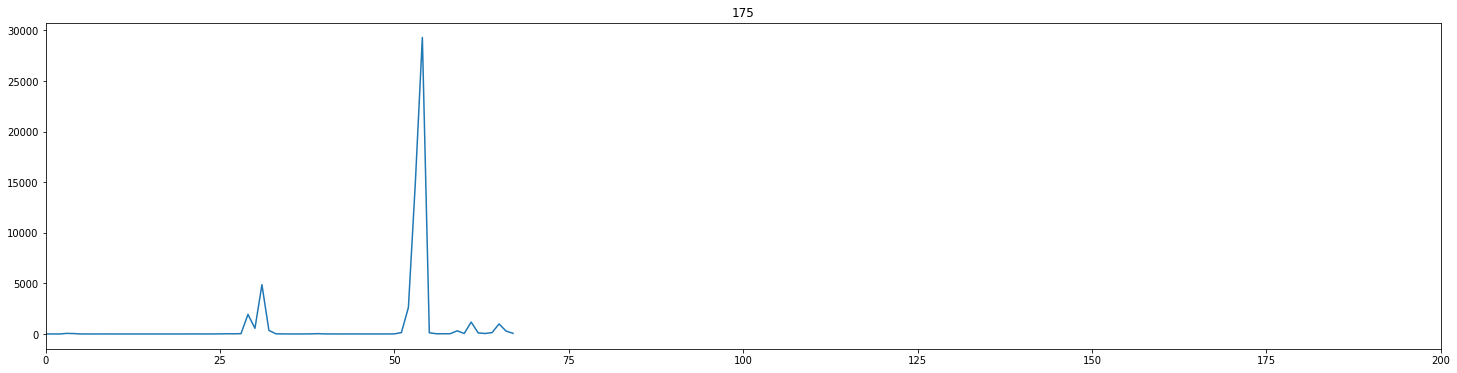

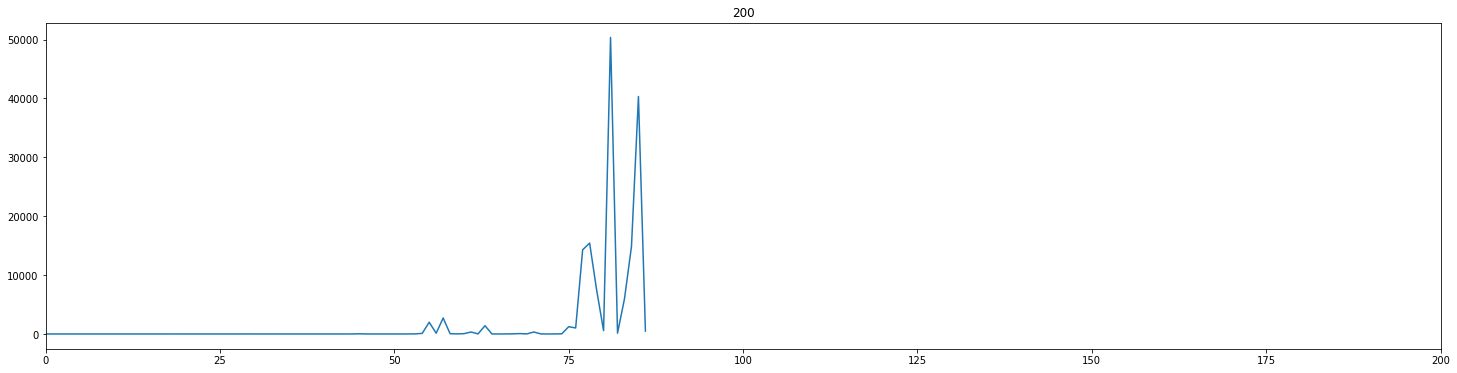

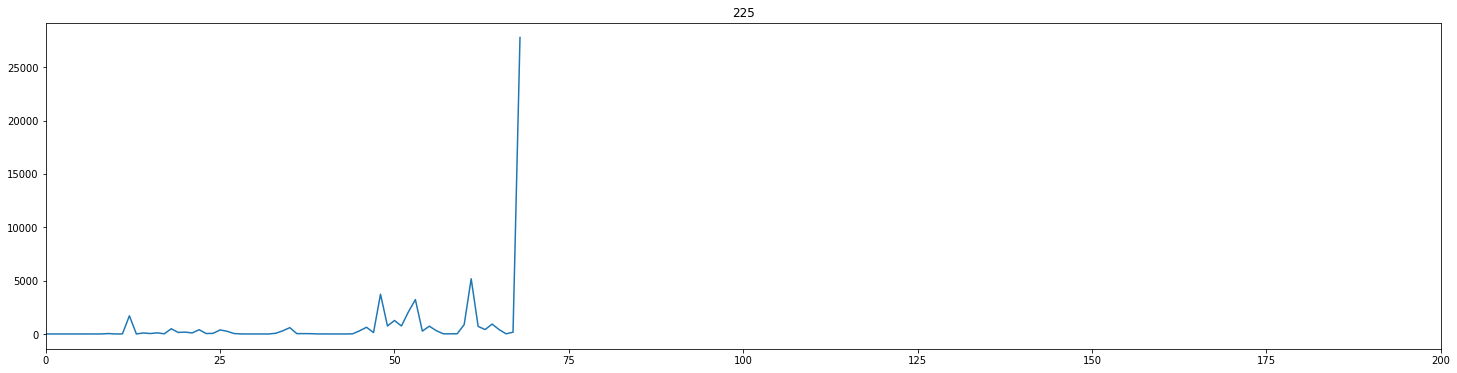

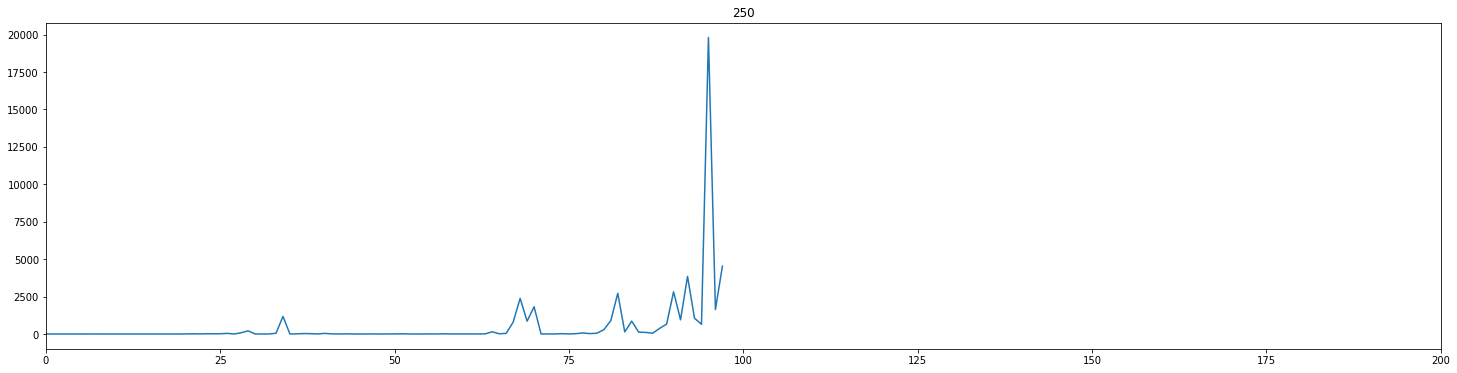

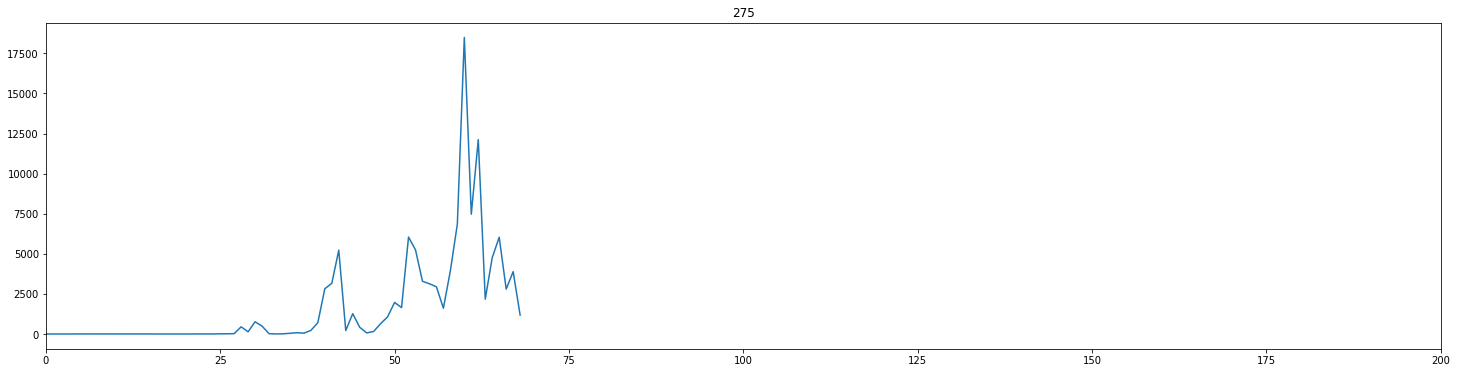

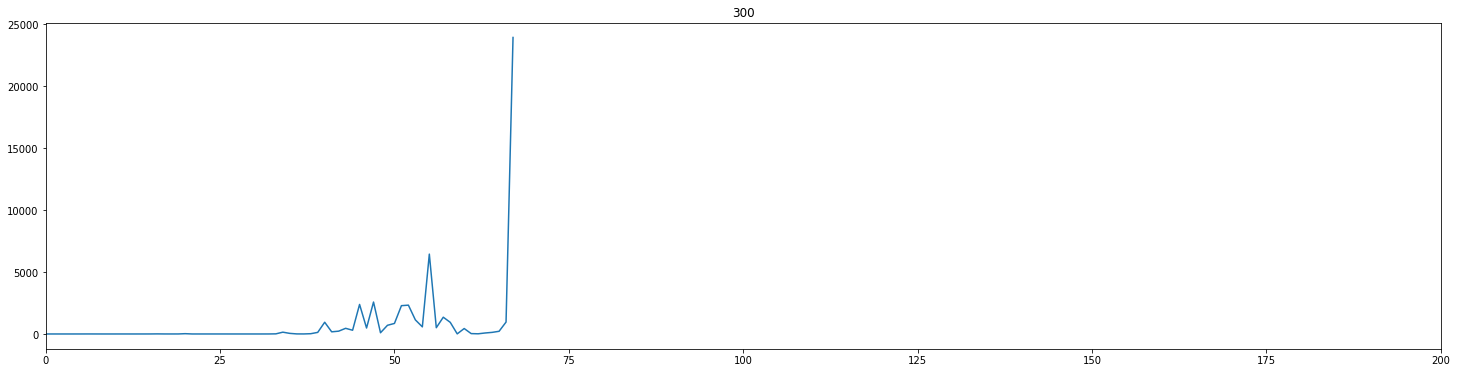

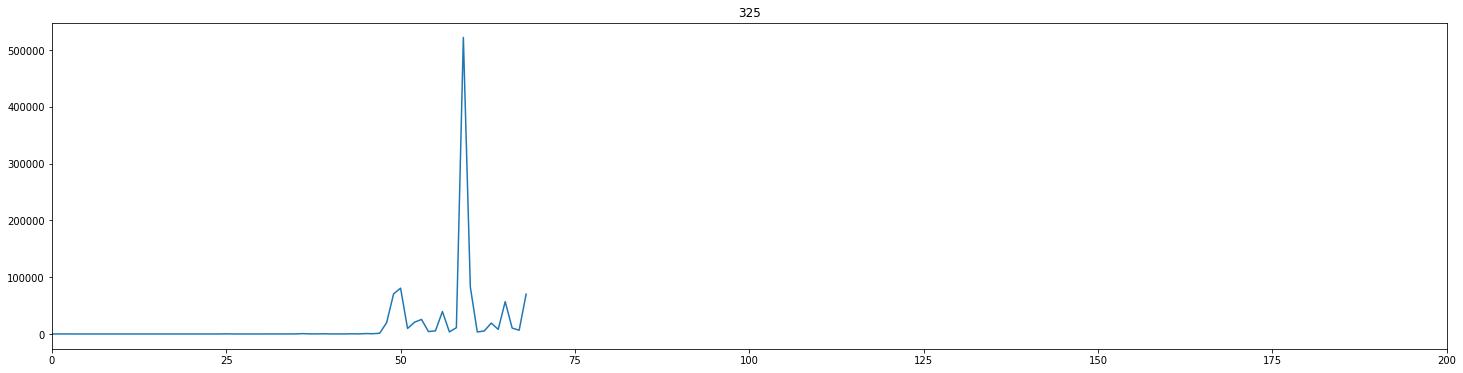

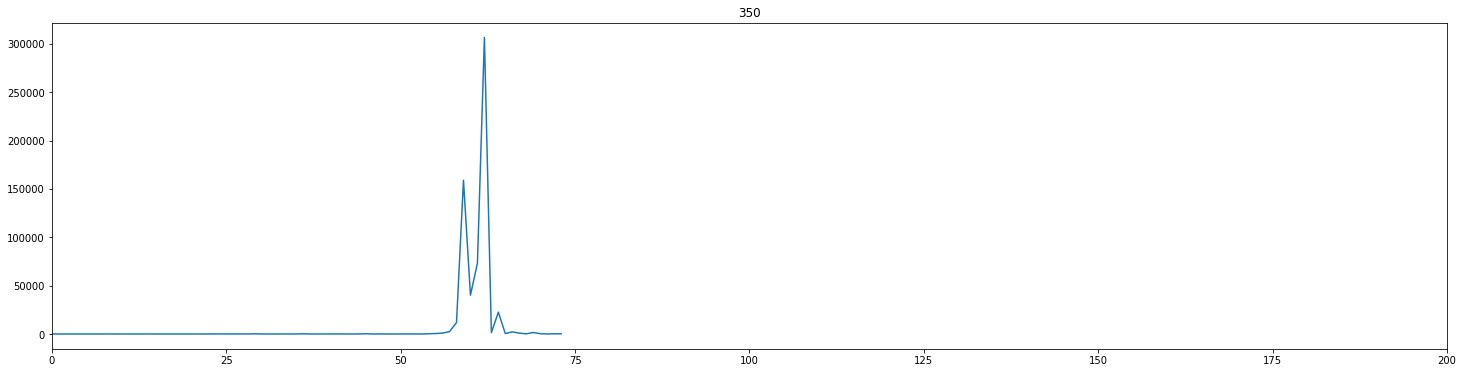

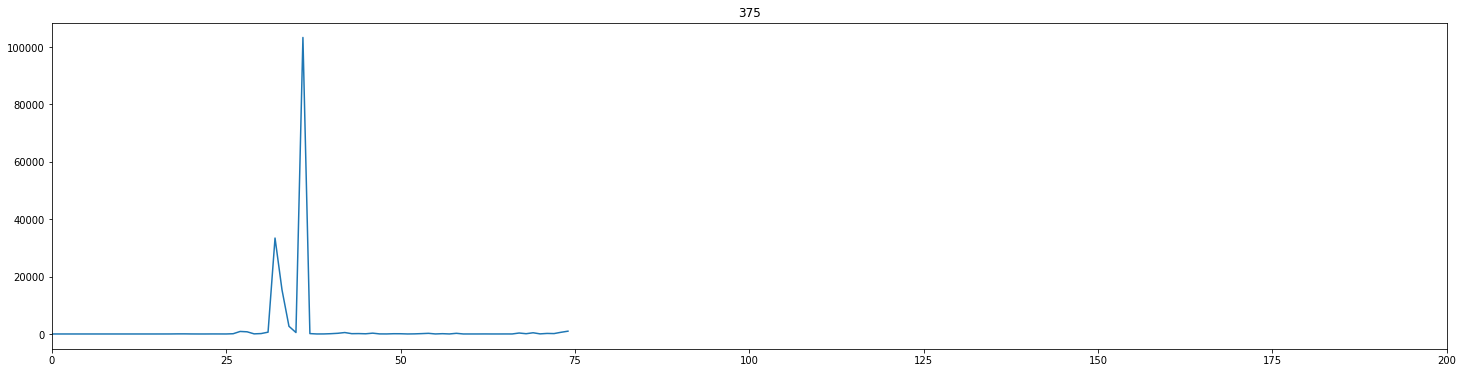

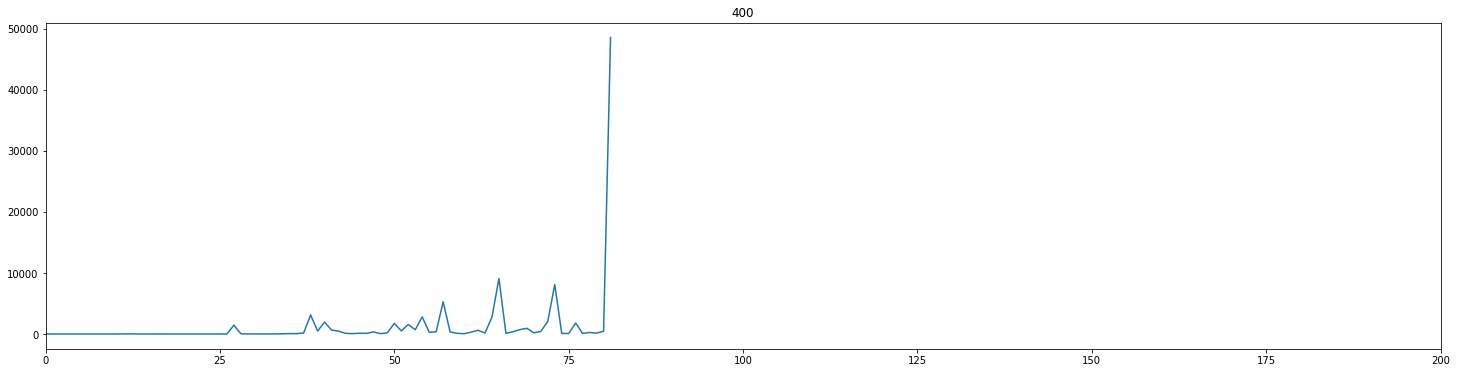

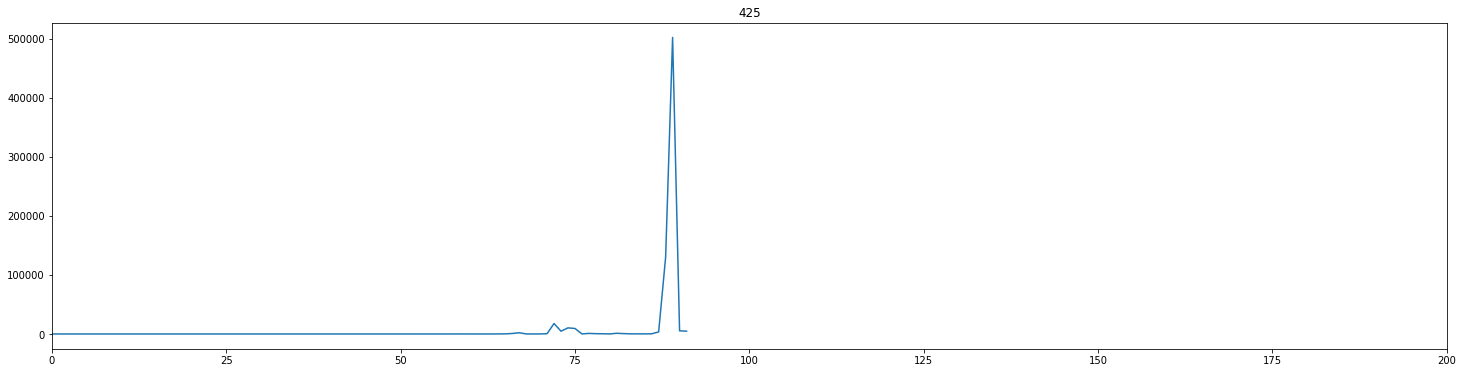

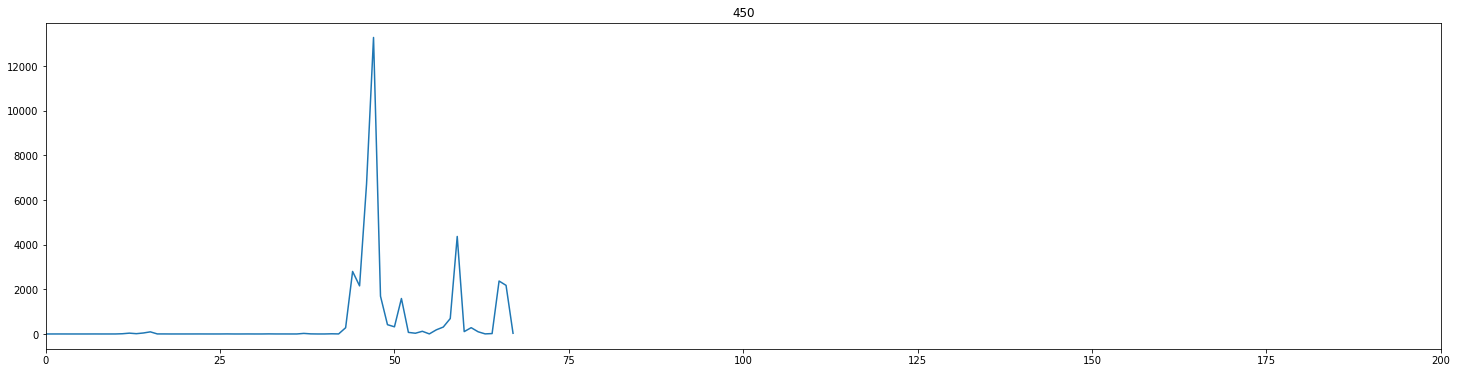

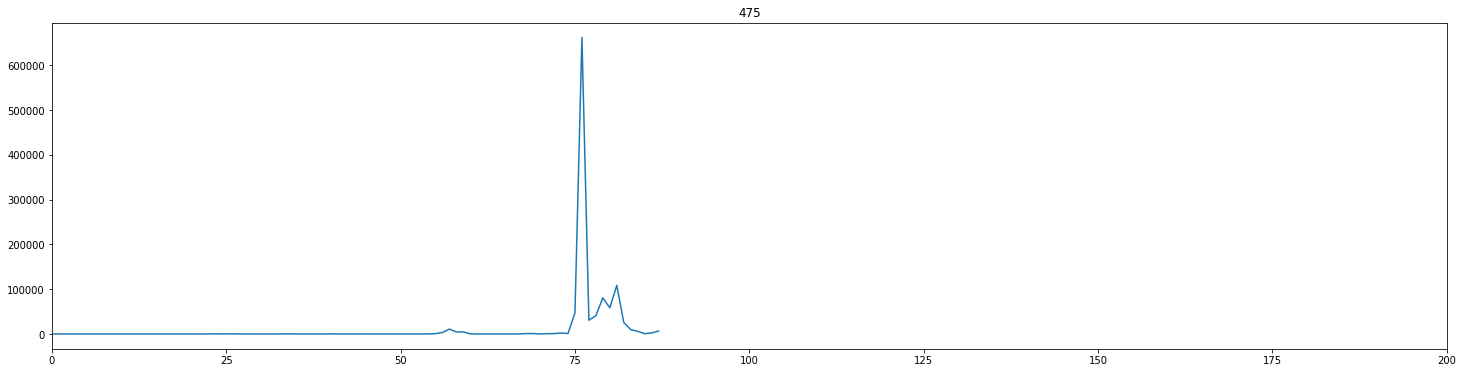

IndexError: list index out of range

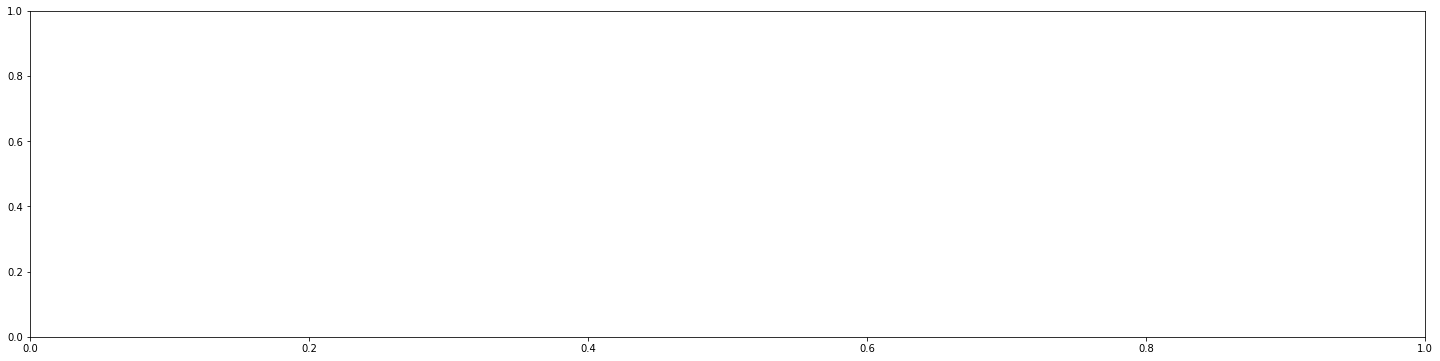

In [10]:
for i in range(0,1000,25):
    f, ax = plt.subplots(figsize=(25,6))
    ax.plot(squared_errors[i])
    plt.title(i)
    ax.set_xlim([0.0,200])
    plt.show()

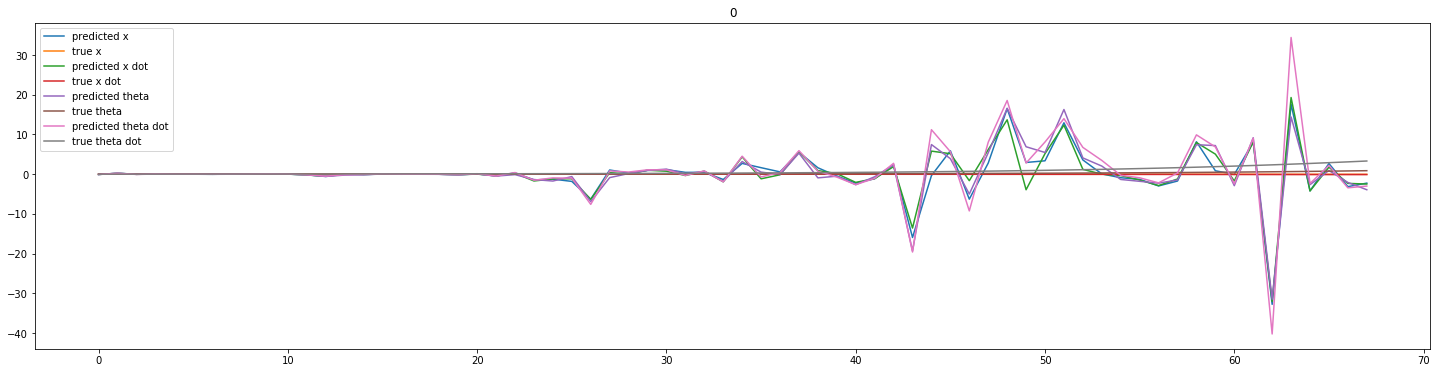

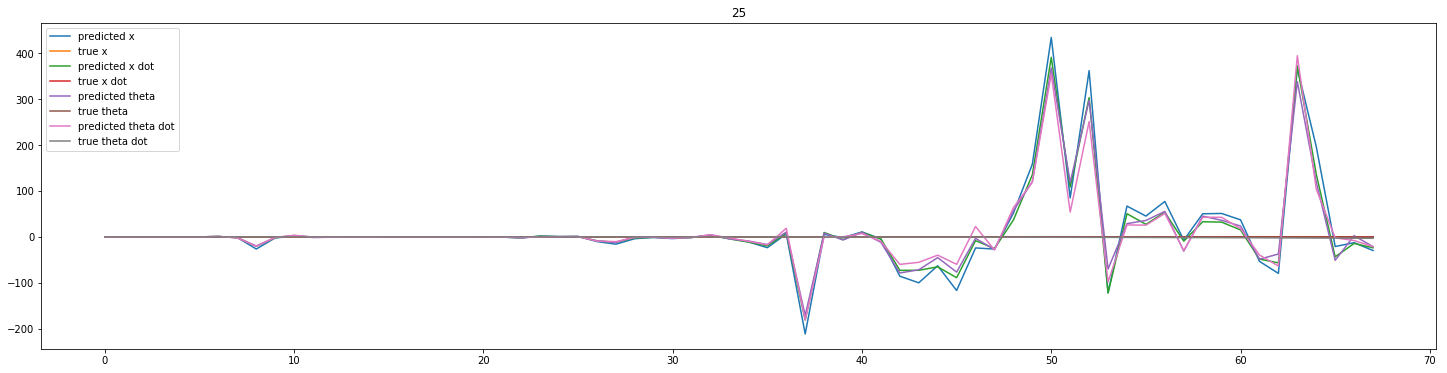

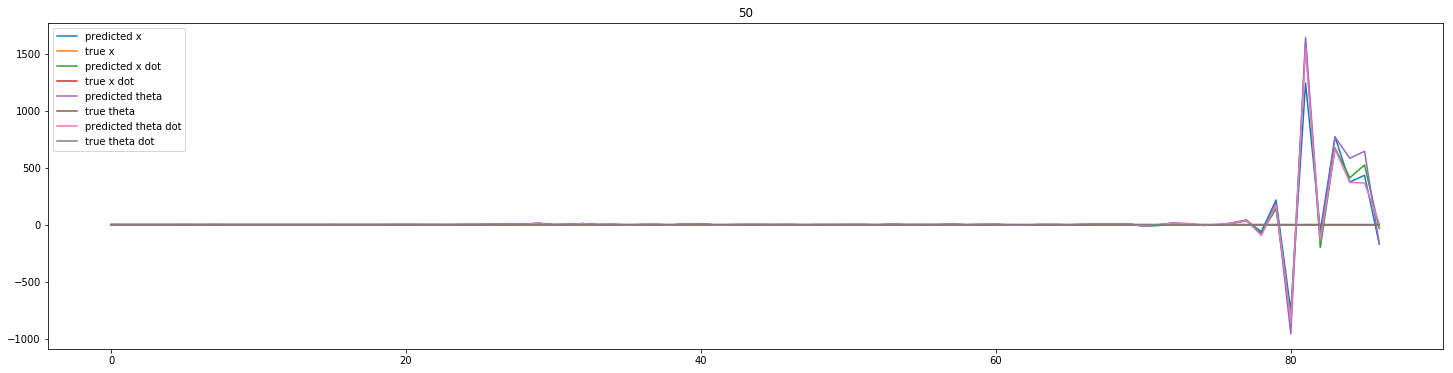

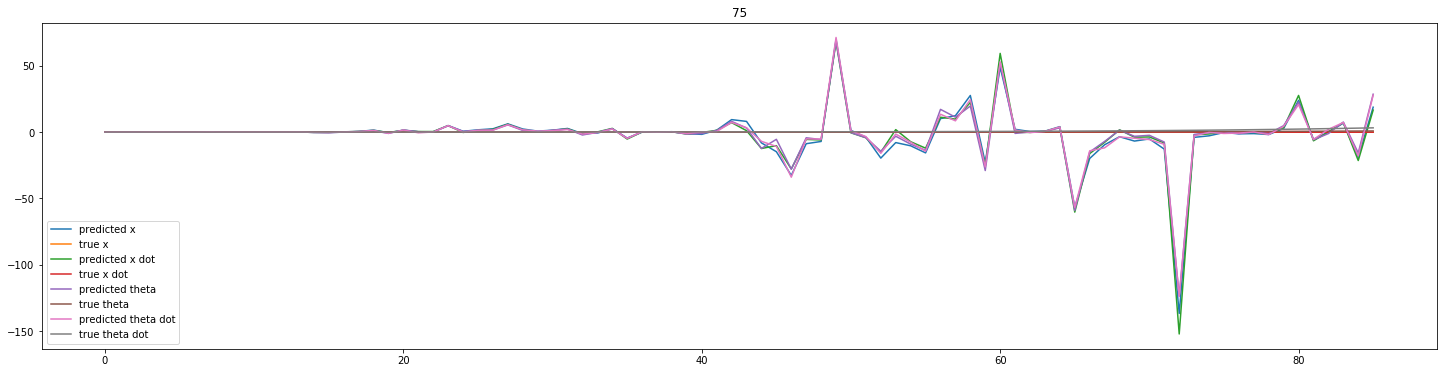

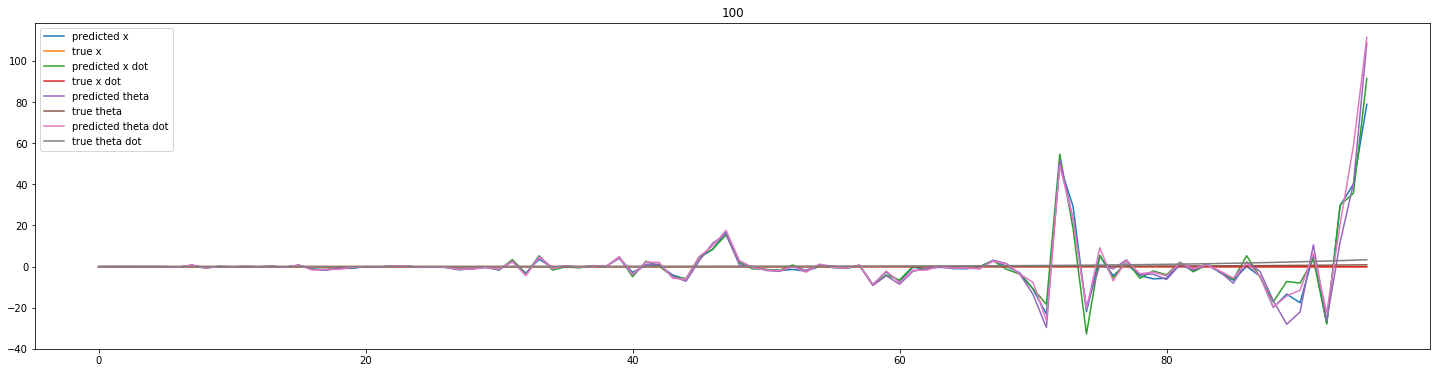

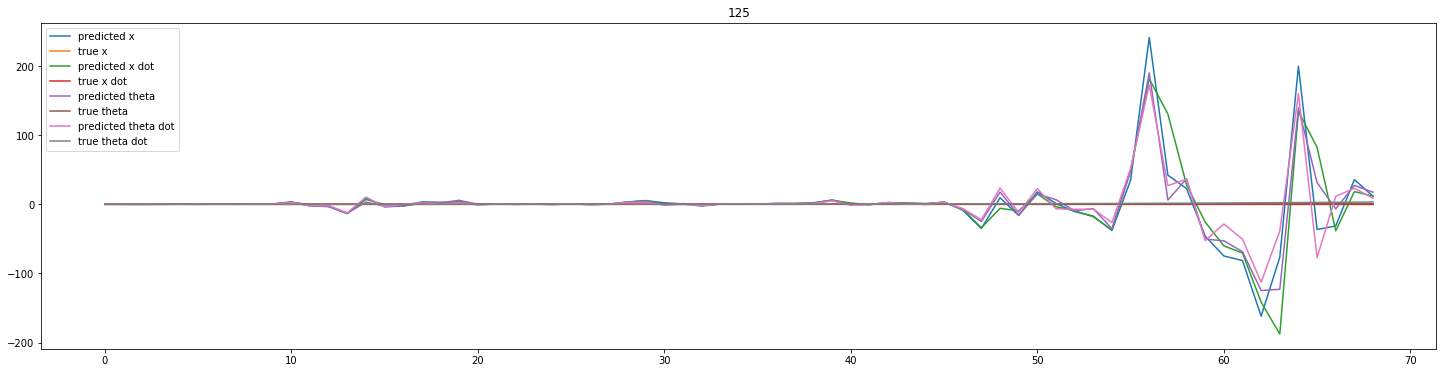

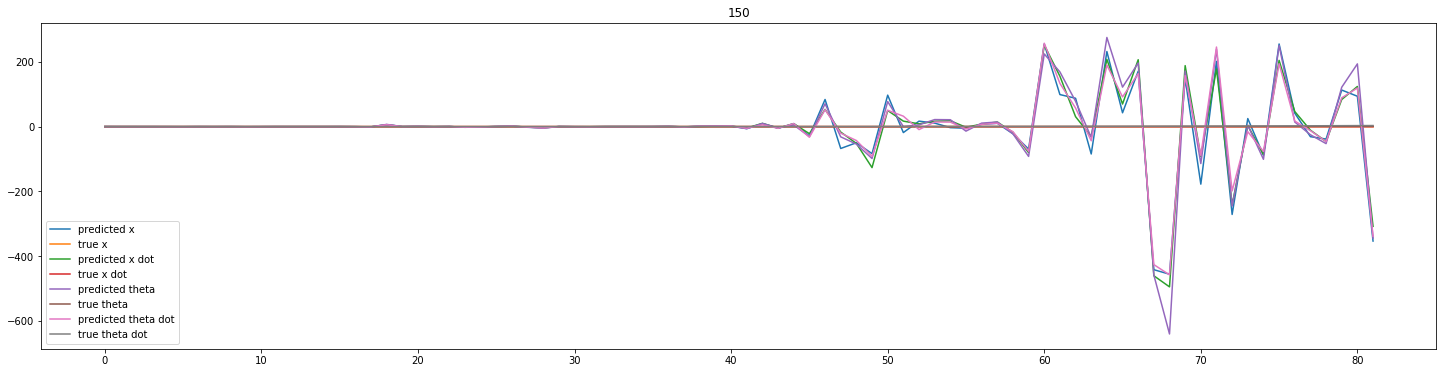

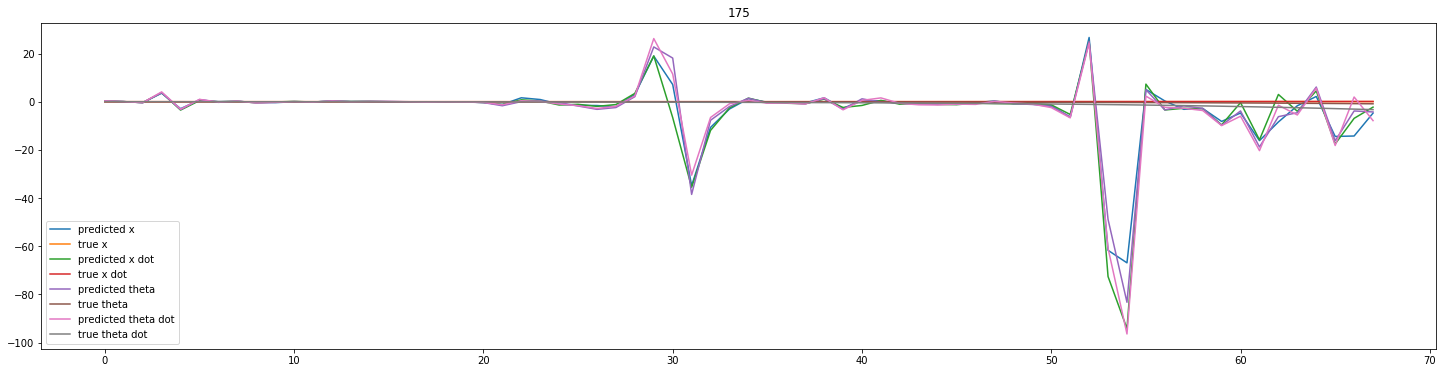

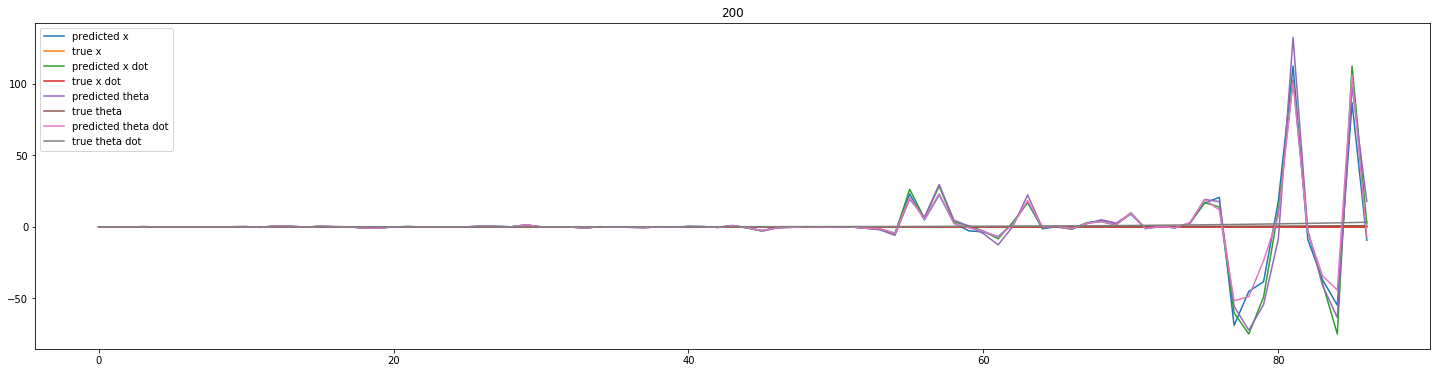

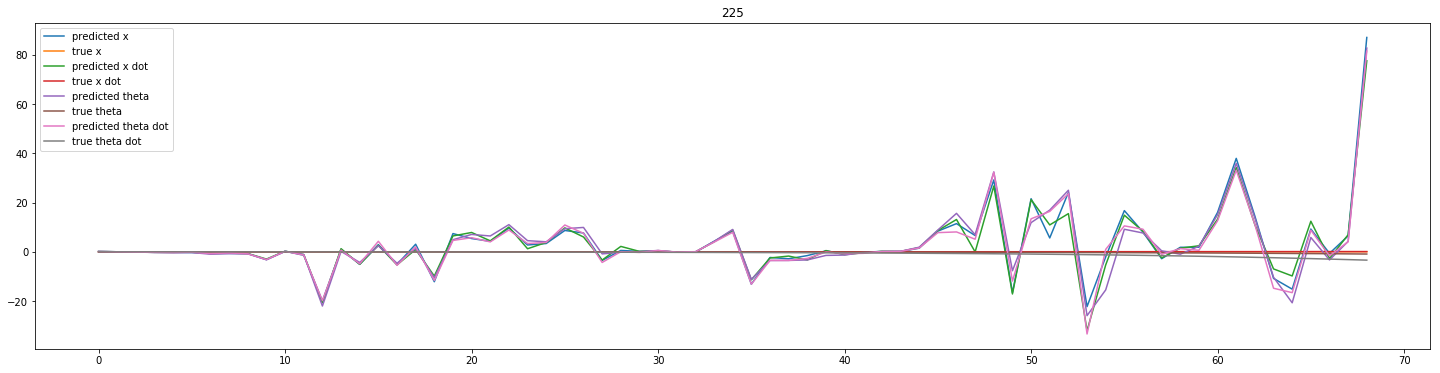

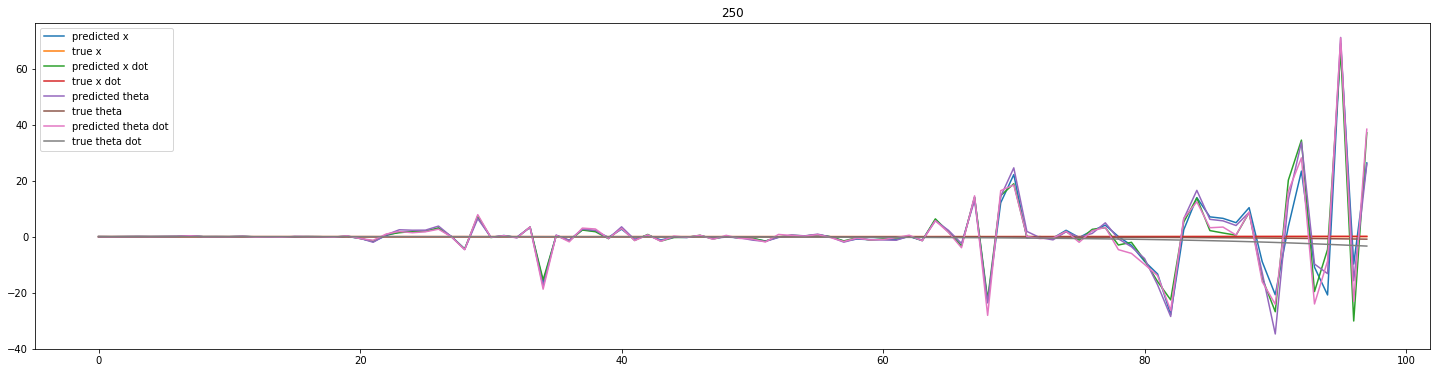

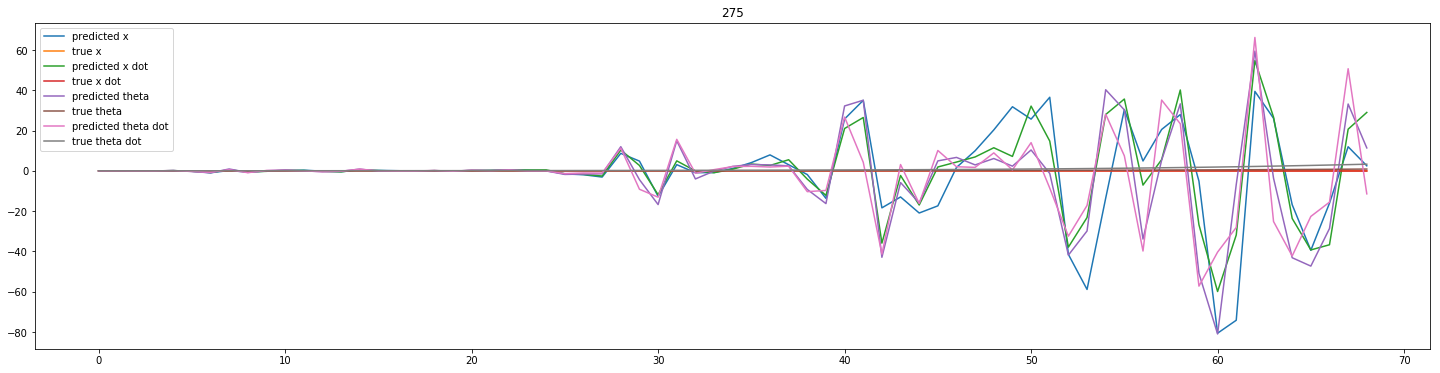

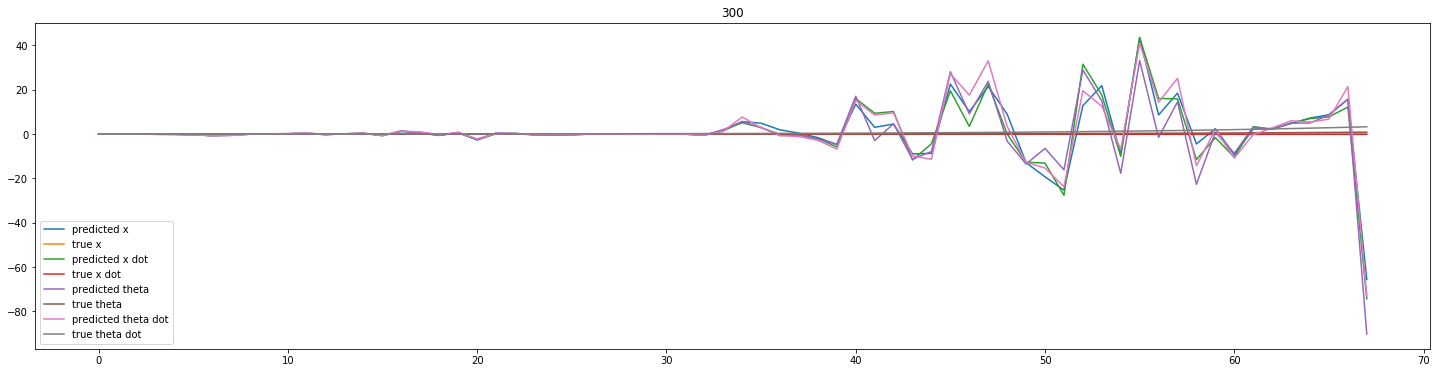

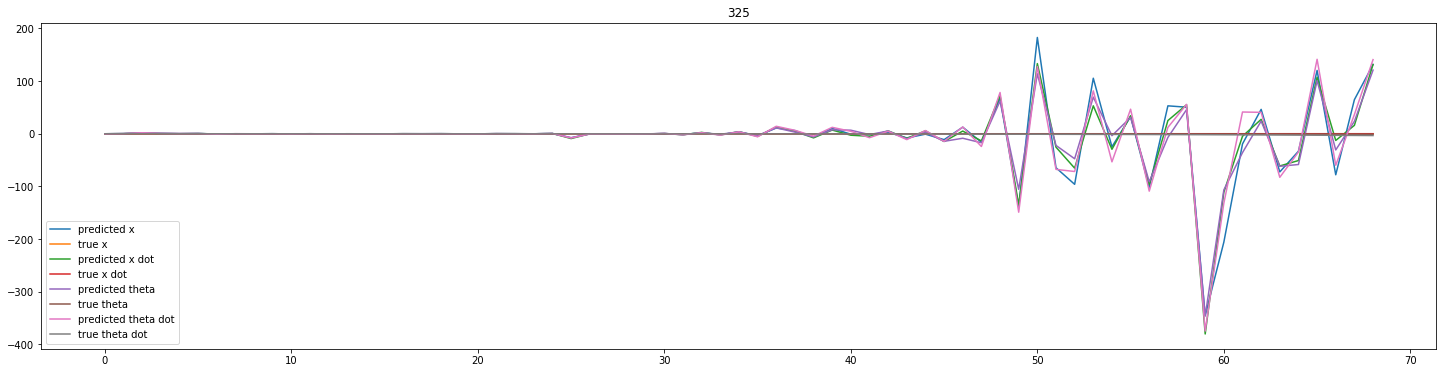

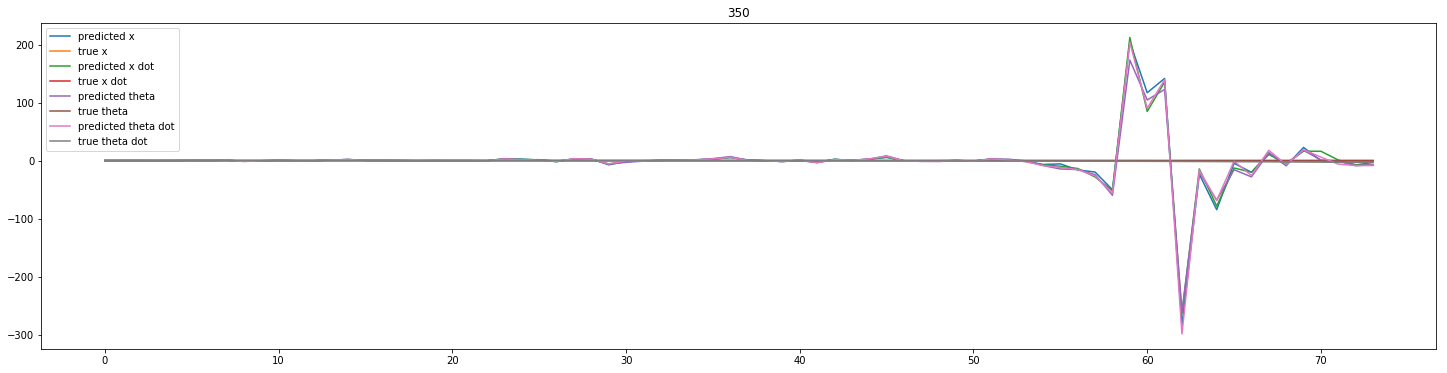

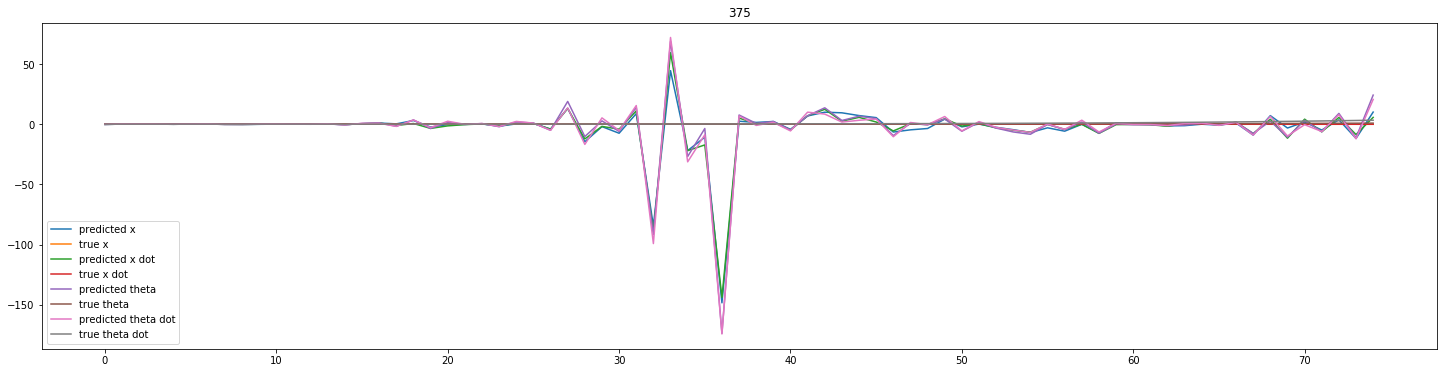

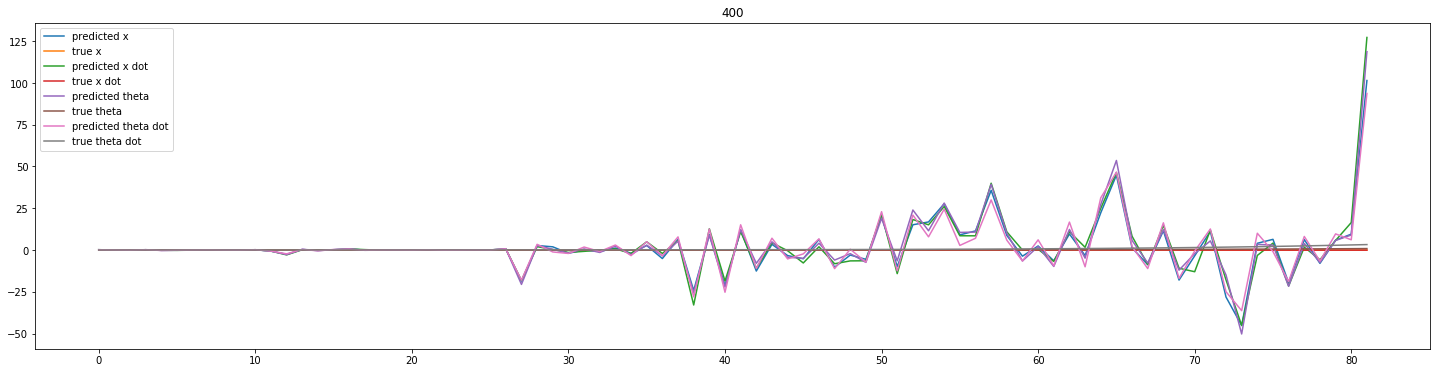

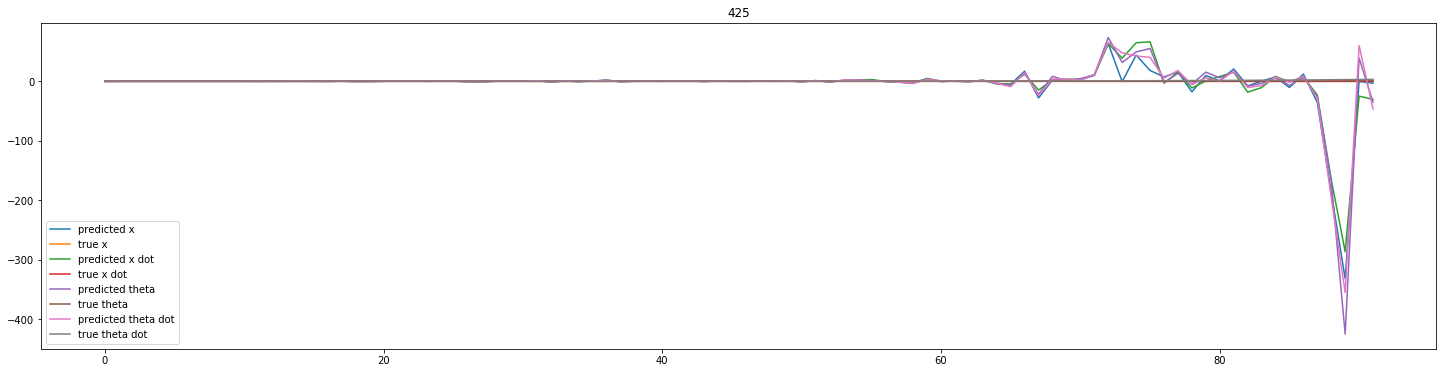

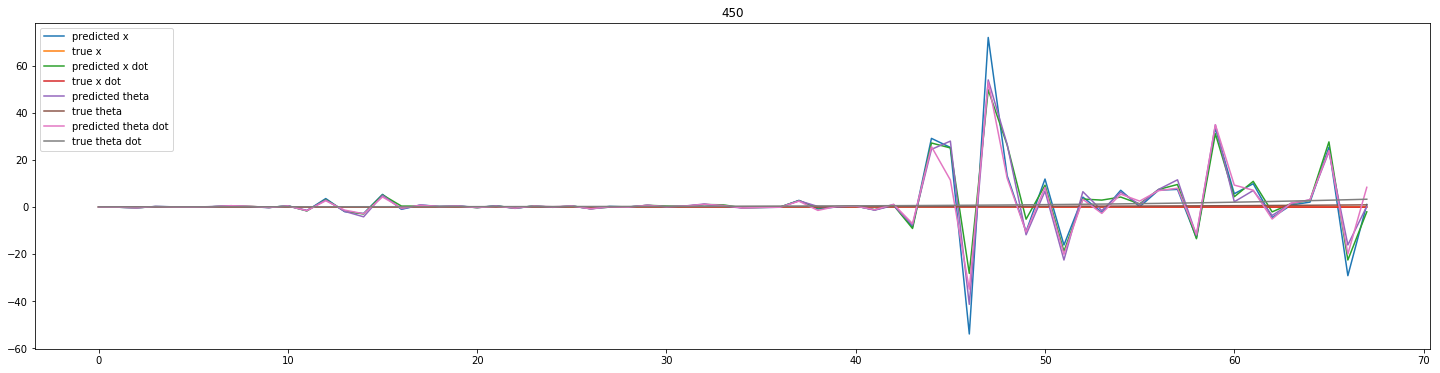

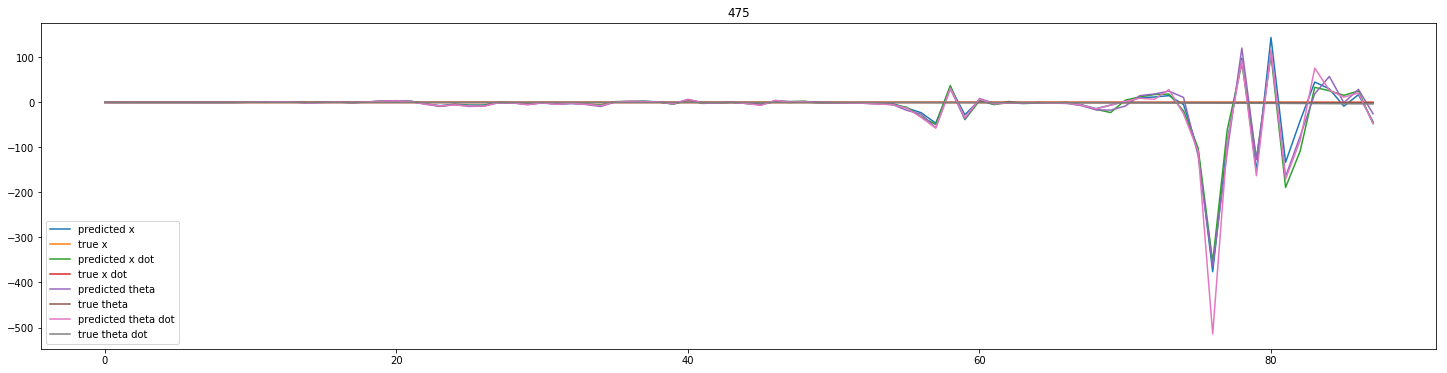

IndexError: list index out of range

<Figure size 1800x432 with 0 Axes>

In [11]:
predictedlabels = ['predicted x', 'predicted x dot', 'predicted theta', 'predicted theta dot']
truelabels = ['true x','true x dot', 'true theta','true theta dot']
for k in range(0,1000,25):
    plt.figure(figsize=(25,6))
    for j in range(4):
        plt.plot([predicted_trajectories[k][i][j] for i in range(len(predicted_trajectories[k]))], label = predictedlabels[j])
        plt.plot([actual_trajectories[k][i][j] for i in range(len(actual_trajectories[k]))], label = truelabels[j])
#     plt.legend(['x', 'x dot','theta', 'theta dot', 'x', 'x dot','theta', 'theta dot'])
    plt.legend()
    plt.title(k)
    plt.show()